# Analiza danych o warunkach pogodowych w Londynie



---



## Skład zespołu:


## Cel projektu:
Celem projektu jest opracowanie modelu regresji pokazującego trend w wybranym
zbiorze danych, wraz z jego analizą.

## Opis zbioru danych:
Analizowany zbiór danych powstał poprzez połączenie dwóch zbiorów:
* zbioru danych zawierającego dzienne pomiary warunków pogodowych ze stacji meteorologicznej w pobliżu lotniska Heathrow w Londynie w latach 1979-2020:
  * dane udostępnione przez `European Climate Assessment (ECA)`
  * https://www.kaggle.com/datasets/emmanuelfwerr/london-weather-data
  * https://www.ecad.eu/dailydata/index.php
* zbioru danych zawierającego dzienne pomiary poziomu rezerwuarów wodnych w Londynie:
  * dane udostępnione przez `Environment Agency`
  * https://data.london.gov.uk/dataset/london-reservoir-levels
  * https://www.gov.uk/government/collections/water-situation-reports-for-england



---



## Przygotowanie środowiska wykonawczego

### Pliki wejściowe

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
weather_csv_file = '/content/drive/MyDrive/med/london_weather.csv'
reservoir_csv_file = '/content/drive/MyDrive/med/london_reservoir_levels.csv'
merged_csv_file = '/content/drive/MyDrive/med/merged_data.csv'
eda_csv_file = '/content/drive/MyDrive/med/eda_data.csv'

### Zaimportowanie potrzebnych bibliotek

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from tabulate import tabulate



---



## Przygotowanie zbioru danych

### df_weather - stan początkowy

In [ ]:
df_weather = pd.read_csv(weather_csv_file)
df_weather.head()

date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0  19790101          2.0       7.0              52.0       2.3       -4.1   
1  19790102          6.0       1.7              27.0       1.6       -2.6   
2  19790103          5.0       0.0              13.0       1.3       -2.8   
3  19790104          8.0       0.0              13.0      -0.3       -2.6   
4  19790105          6.0       2.0              29.0       5.6       -0.8   

   min_temp  precipitation  pressure  snow_depth  
0      -7.5            0.4  101900.0         9.0  
1      -7.5            0.0  102530.0         8.0  
2      -7.2            0.0  102050.0         4.0  
3      -6.5            0.0  100840.0         2.0  
4      -1.4            0.0  102250.0         1.0

In [ ]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341 non-null  int64  
 1   cloud_cover       15322 non-null  float64
 2   sunshine          15341 non-null  float64
 3   global_radiation  15322 non-null  float64
 4   max_temp          15335 non-null  float64
 5   mean_temp         15305 non-null  float64
 6   min_temp          15339 non-null  float64
 7   precipitation     15335 non-null  float64
 8   pressure          15337 non-null  float64
 9   snow_depth        13900 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB


In [ ]:
print(f"Oldest record: {df_weather['date'].min()}")
print(f"Newest record: {df_weather['date'].max()}")

Oldest record: 19790101
Newest record: 20201231


Zbiór danych `london_weather.csv` zawiera kolumnę z datą w formacie 'YYYYMMDD' (od 1 stycznia 1979 do 31 grudnia 2020), którą użyjemy do połączenia ze zbiorem `london_reservoir_levels.csv`.

### df_reservoir - stan początkowy

In [ ]:
df_reservoir = pd.read_csv(reservoir_csv_file)
df_reservoir.head()

date month  year  lower_lee_group   lower_thames_group 
0  01-Jan-89   Jan  1989                83                   76
1  02-Jan-89   Jan  1989                83                   75
2  03-Jan-89   Jan  1989                83                   75
3  04-Jan-89   Jan  1989                82                   75
4  05-Jan-89   Jan  1989                82                   75

In [ ]:
df_reservoir.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12783 entries, 0 to 12782
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   date                  12783 non-null  object
 1   month                 12783 non-null  object
 2   year                  12783 non-null  int64 
 3    lower_lee_group      12783 non-null  object
 4    lower_thames_group   12783 non-null  object
dtypes: int64(1), object(4)
memory usage: 499.5+ KB


In [ ]:
import re

pattern = re.compile(r'^\d{2}-[a-zA-Z]{3}-\d{2}$')

different_format = df_reservoir[~df_reservoir['date'].apply(lambda x: bool(pattern.match(str(x))))]
print(len(different_format), different_format.iloc[0,0])

122 01/06/2020


In [ ]:
df_reservoir['month'].unique()

array(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
       'Oct', 'Nov', 'Dec', 'June', 'July'], dtype=object)

Zbiór `london_reservoir_data.csv` zawiera 5 kolumn:
* `date` - data w niejednolitym formacie ('DD-Mon-YY' lub 'DD/MM/YYYY')
* `month` - skrócona nazwa miesiąca w niejednolitym formacie (3 lub 4 litery)
* `year` - pełny rok
* `lower_lee_group` - procent użytkowej pojemności wody w rezerwuarach 'Grupy Dolnej Lei' [%]
* `lower_thames_group` - procent użytkowej pojemności wody w rezerwuarach 'Grupy Dolnej Tamizy' [%]

Z tego zbioru interesuje nas data pomiaru, którą uzyskamy w kolumn `date`, `month` i `year` oraz `lower_thames_group`. Zmienna `lower_lee_group` zostanie pominięta.

### df_reservoir - przygotowanie

In [ ]:
month_abbreviations = {'June': 'Jun', 'July': 'Jul'}
df_reservoir['month'] = df_reservoir['month'].replace(month_abbreviations)
df_reservoir['month'].unique()

array(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
       'Oct', 'Nov', 'Dec'], dtype=object)

In [ ]:
from datetime import datetime

def month_to_number(month_name):
  datetime_object = datetime.strptime(month_name, "%b")
  month_number = datetime_object.month
  formatted_month = f"{month_number:02d}"
  return formatted_month

In [ ]:
df_reservoir['parsed_date'] = (df_reservoir['year'].astype(str) + df_reservoir['month'].apply(month_to_number).astype(str) + df_reservoir['date'].str[:2]).astype(int)
df_reservoir.head()

date month  year  lower_lee_group   lower_thames_group   parsed_date
0  01-Jan-89   Jan  1989                83                   76     19890101
1  02-Jan-89   Jan  1989                83                   75     19890102
2  03-Jan-89   Jan  1989                83                   75     19890103
3  04-Jan-89   Jan  1989                82                   75     19890104
4  05-Jan-89   Jan  1989                82                   75     19890105

In [ ]:
print(f"Oldest record: {df_reservoir['parsed_date'].min()}")
print(f"Newest record: {df_reservoir['parsed_date'].max()}")

Oldest record: 19890101
Newest record: 20231231


Po zmianie formatu daty na 'YYYYMMDD' możemy zaobserwować, że zbiór `london_weather.csv` zawiera dane z innego okresu niż `london_reservoir_levels.csv`. Przyjmiemy tylko dane ze wspólnego okresu od 1 stycznia 1989 do 31 grudnia 2020.

In [ ]:
df_reservoir = df_reservoir[df_reservoir['year'] < 2021]

In [ ]:
print(df_reservoir.columns)
df_reservoir['lower_thames_group'] = df_reservoir[' lower_thames_group ']
df_reservoir['lower_thames_group'].unique()

Index(['date', 'month', 'year', ' lower_lee_group ', ' lower_thames_group ',
       'parsed_date'],
      dtype='object')


array(['76', '75', '74', '77', '78', '79', '80', '81', '82', '83', '84',
       '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95',
       '96', '97', '98', '73', '72', '71', '70', '69', '68', '67', '66',
       '65', '64', '63', '62', '61', '60', '59', '58', '57', '56', '55',
       '54', '53', '52', '51', '50', '49', '48', '99', ' --- ', '47',
       '46', '45', '44', '43', '42', '100', ' n/a '], dtype=object)

Zmienna `lower_thames_group` oprócz liczb całkowitych zawiera oznaczenia wartości brakujących ' --- ' oraz ' n/a '. Zamienimy te brakujące dane na NaN, aby zająć się nimi na późniejszym etapie.

In [ ]:
df_reservoir['lower_thames_group'].replace([' --- ', ' n/a '], np.nan, inplace=True)
df_reservoir['lower_thames_group'].unique()

array(['76', '75', '74', '77', '78', '79', '80', '81', '82', '83', '84',
       '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95',
       '96', '97', '98', '73', '72', '71', '70', '69', '68', '67', '66',
       '65', '64', '63', '62', '61', '60', '59', '58', '57', '56', '55',
       '54', '53', '52', '51', '50', '49', '48', '99', nan, '47', '46',
       '45', '44', '43', '42', '100'], dtype=object)

In [ ]:
df_reservoir = df_reservoir[['parsed_date', 'lower_thames_group']]
df_reservoir.head()

parsed_date lower_thames_group
0     19890101                 76
1     19890102                 75
2     19890103                 75
3     19890104                 75
4     19890105                 75

### df_weather - przygotowanie

In [ ]:
df_weather = df_weather[df_weather['date'] > 19881231]
print(f"Oldest record: {df_weather['date'].min()}")
print(f"Newest record: {df_weather['date'].max()}")

Oldest record: 19890101
Newest record: 20201231


Przygotowanie zbioru `london_weather.csv` do połączenia sprowadza się do ograniczenia okresu pomiarów.

### Połączenie ramek danych

In [ ]:
df = pd.merge(df_weather, df_reservoir, left_on='date', right_on='parsed_date', how='inner')
df.drop(columns='parsed_date', inplace=True)
df.head()

date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0  19890101          7.0       0.0              13.0       8.2        7.4   
1  19890102          6.0       0.0              13.0       9.5        7.1   
2  19890103          8.0       0.0              13.0      11.2        6.2   
3  19890104          5.0       3.8              39.0      11.1        8.0   
4  19890105          5.0       0.0              13.0      10.7        6.2   

   min_temp  precipitation  pressure  snow_depth lower_thames_group  
0       6.6            0.0  103870.0         0.0                 76  
1       6.0            0.0  103550.0         0.0                 75  
2       3.0            0.4  102950.0         0.0                 75  
3       4.8            0.0  102530.0         0.0                 75  
4       1.2            3.7  102340.0         0.0                 75

In [ ]:
df.to_csv(merged_csv_file, index=False)



---



## Analiza eksploracyjna danych

In [ ]:
df = pd.read_csv(merged_csv_file)
df.head()

date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0  19890101          7.0       0.0              13.0       8.2        7.4   
1  19890102          6.0       0.0              13.0       9.5        7.1   
2  19890103          8.0       0.0              13.0      11.2        6.2   
3  19890104          5.0       3.8              39.0      11.1        8.0   
4  19890105          5.0       0.0              13.0      10.7        6.2   

   min_temp  precipitation  pressure  snow_depth  lower_thames_group  
0       6.6            0.0  103870.0         0.0                76.0  
1       6.0            0.0  103550.0         0.0                75.0  
2       3.0            0.4  102950.0         0.0                75.0  
3       4.8            0.0  102530.0         0.0                75.0  
4       1.2            3.7  102340.0         0.0                75.0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11688 entries, 0 to 11687
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                11688 non-null  int64  
 1   cloud_cover         11682 non-null  float64
 2   sunshine            11688 non-null  float64
 3   global_radiation    11669 non-null  float64
 4   max_temp            11682 non-null  float64
 5   mean_temp           11652 non-null  float64
 6   min_temp            11686 non-null  float64
 7   precipitation       11682 non-null  float64
 8   pressure            11685 non-null  float64
 9   snow_depth          10247 non-null  float64
 10  lower_thames_group  11675 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 1004.6 KB


Zbiór danych zawiera 11688 obserwacji opisywanych 11 atrybutami:
* `date` - data obserwacji w formacie YYYYMMDD
* `cloud_cover` - zachmurzenie [okta]
* `sunshine` - usłonecznienie [godz.]
* `global_radiation` - natężenie napromieniowania [W/m^2]
* `max_temp` - maksymalna temperatura [°C]
* `mean_temp` - średnia temperatura [°C]
* `min_temp` - minimalna temperatura [°C]
* `predipitation` - opad atmosferyczny [mm]
* `pressure` - ciśnienie atmosferyczne [Pa]
* `snow_depth` - głębokość pokrywy śnieżnej [cm]
* `lower_thames_group` - procent użytkowej pojemności wody w rezerwuarach 'Grupy Dolnej Tamizy' [%]

In [ ]:
df['date'] = df['date'].astype(str)

df['year'] = df['date'].str[:4].astype(int)
df['month'] = df['date'].str[4:6].astype(int)

df.drop(columns=['date'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11688 entries, 0 to 11687
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cloud_cover         11682 non-null  float64
 1   sunshine            11688 non-null  float64
 2   global_radiation    11669 non-null  float64
 3   max_temp            11682 non-null  float64
 4   mean_temp           11652 non-null  float64
 5   min_temp            11686 non-null  float64
 6   precipitation       11682 non-null  float64
 7   pressure            11685 non-null  float64
 8   snow_depth          10247 non-null  float64
 9   lower_thames_group  11675 non-null  float64
 10  year                11688 non-null  int64  
 11  month               11688 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 1.1 MB


Rozdzielono atrybut `date` na atrybuty `year` i `month`, aby ułatwić analizę wpływu daty na resztę atrybutów oraz ewentualnie użyć część daty w modelu regresji.

### Analiza zmienności

In [ ]:
attributes = ['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'mean_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth', 'lower_thames_group']
df[attributes].describe()

cloud_cover      sunshine  global_radiation      max_temp  \
count  11682.000000  11688.000000      11669.000000  11682.000000   
mean       5.211008      4.444208        120.026052     15.709587   
std        2.112674      4.080662         89.825141      6.535435   
min        0.000000      0.000000          8.000000     -3.400000   
25%        4.000000      0.500000         41.000000     10.800000   
50%        6.000000      3.600000         96.000000     15.300000   
75%        7.000000      7.300000        188.000000     20.600000   
max        9.000000     16.000000        402.000000     37.900000   

          mean_temp      min_temp  precipitation       pressure    snow_depth  \
count  11652.000000  11686.000000   11682.000000   11685.000000  10247.000000   
mean      11.777394      7.840108       1.664355  101539.717587      0.019811   
std        5.678592      5.248160       3.710222    1050.808579      0.313497   
min       -5.400000     -9.400000       0.000000   95960.000000      0.000000   
25%        7.400000      3.900000       0.000000  100930.000000      0.000000   
50%       11.600000      8.000000       0.000000  101620.000000      0.000000   
75%       16.300000     11.900000       1.600000  102240.000000      0.000000   
max       29.000000     22.300000      61.800000  104820.000000     12.000000   

       lower_thames_group  
count         11675.00000  
mean             88.19546  
std              11.61589  
min              42.00000  
25%              85.00000  
50%              92.00000  
75%              96.00000  
max             100.00000

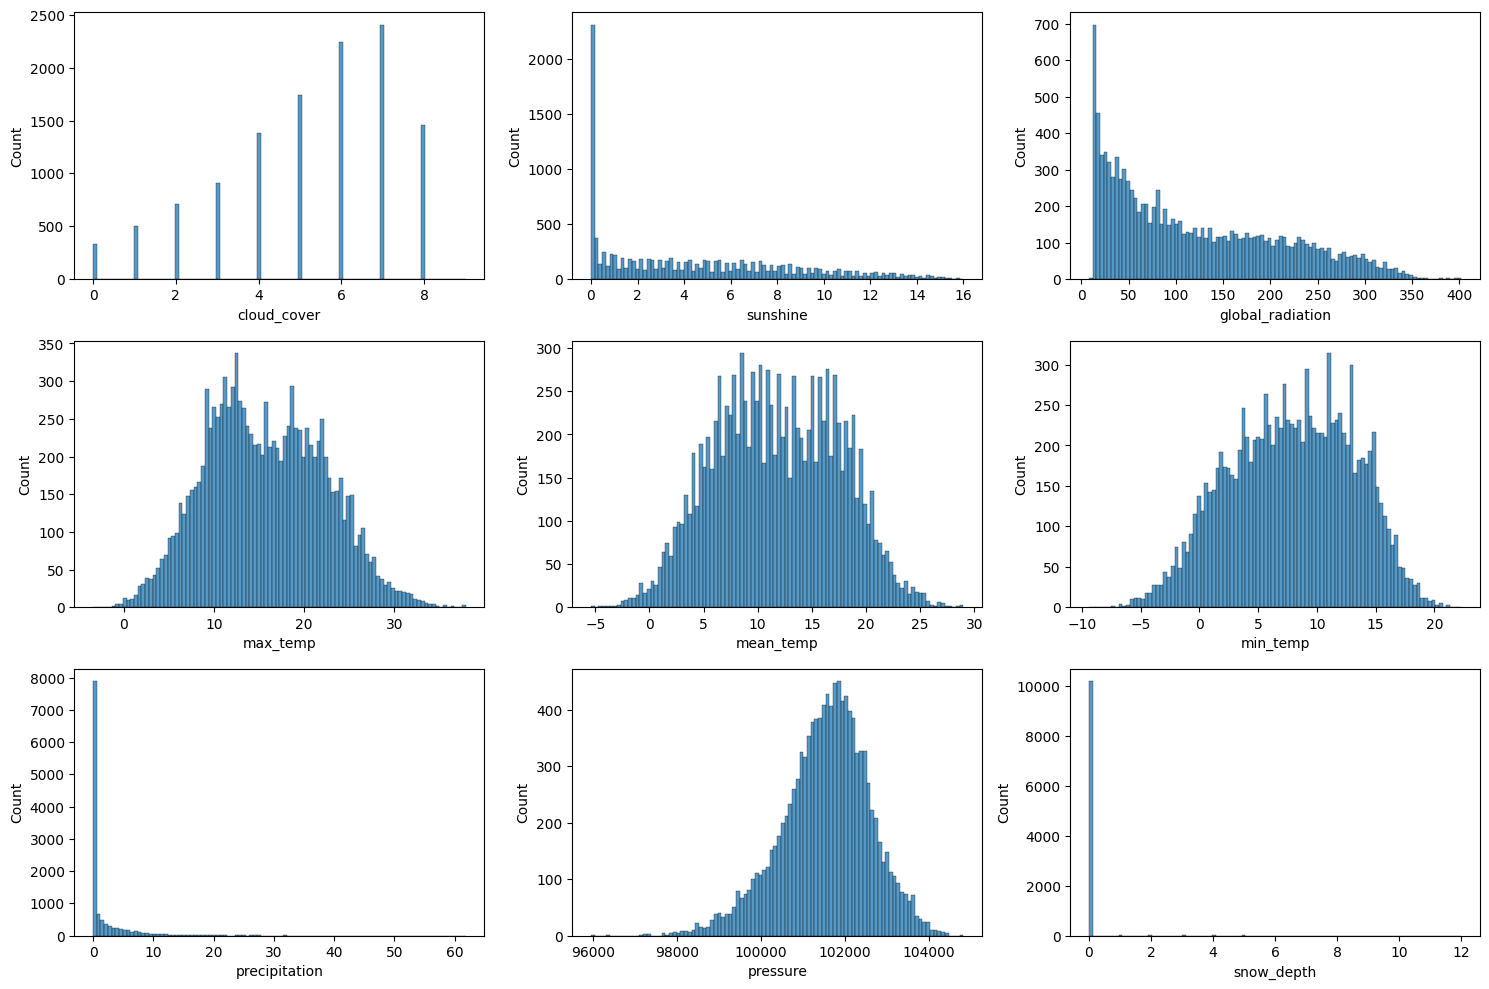

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15,10))
attributes = ['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'mean_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth']

for i, attribute in enumerate(attributes):
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    sns.histplot(data=df, x=attribute, ax=ax, bins=100)

plt.tight_layout()
plt.show()

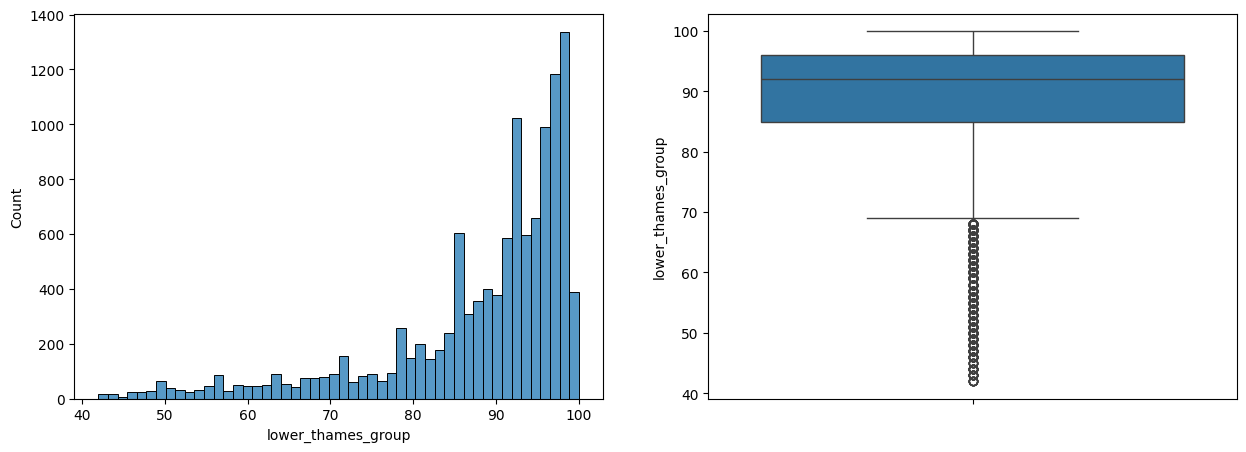

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(data=df, x='lower_thames_group', bins=50, ax=axes[0])
sns.boxplot(y=df['lower_thames_group'], ax=axes[1])
plt.show()

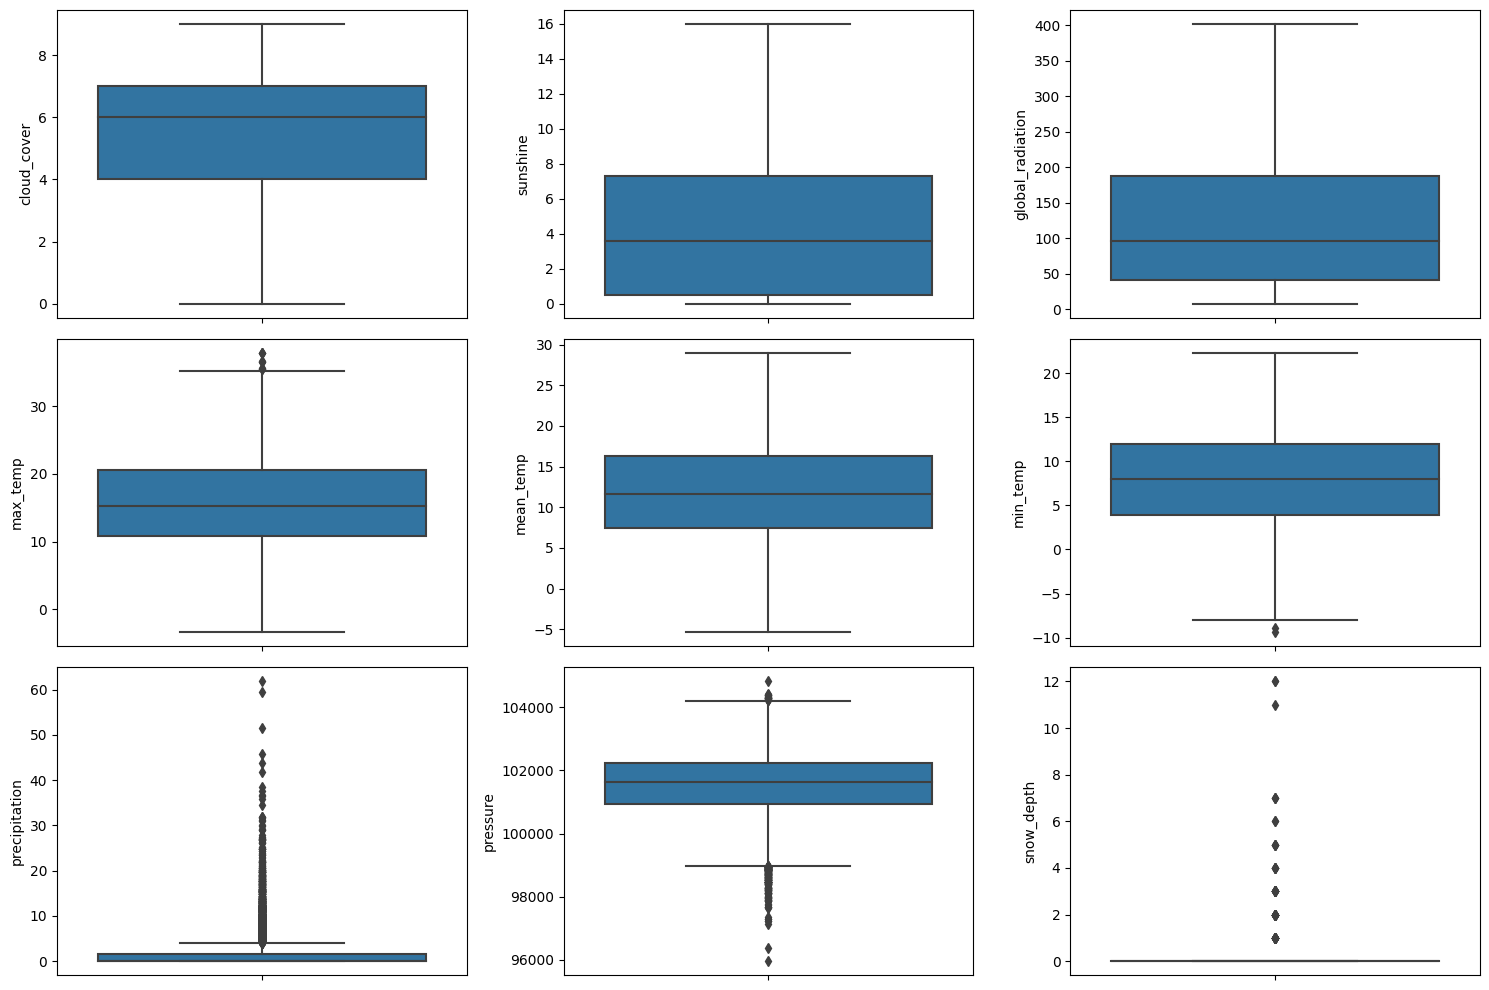

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15,10))
attributes = ['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'mean_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth']

for i, attribute in enumerate(attributes):
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    sns.boxplot(y=df[attribute], ax=ax)

plt.tight_layout()
plt.show()

**Wnioski na temat zmienności:**
* zakresy zmienności:
  * `cloud_cover` przyjmuje tylko wartości całkowite z zakresu 0-9, co zgadza się z definicją jednostki (okta), w której wyrażona jest zmienna
  * `sunshine`, `max_temp`, `mean_temp`, `min_temp`, `precipitation` i `snow_depth` przyjmują wartości zbliżonych rzędów wielkości (< 100)
  * `mean_temp` i `min_temp` mogą przyjmować wartości ujemne
  * `global_radiation` przyjmuje wartości w zakesie ok. 0-400
  * `pressure` ma najszerszy zakres zmienności i przyjmuje wartości największego rzędu
  * `lower_thames_group` przyjmuje wartości poniżej 100 (ok. 40-100), ponieważ jest wyrażona w procentach
* mody:
  * `cloud_cover` najczęściej przyjmuje wartość 7
  * `sunshine`, `precipitation` i `snow_depth` najczęściej przyjmują wartość 0
  * `global_radiation` najczęściej przyjmuje wartość bliską 0
  * `lower_thames_group` najczęściej przyjmuje wartości z zakresu 90-100
* wartości odstające:
  * `precipitation` i `snow_depth` mają wiele wartości odstających w prawej części rozkładu
  * `pressure` ma wartości odstające na obydwu skrajach rozkładu
  * `max_temp` ma pojedyncze wartości odstające po prawej stronie rozkładu
  * `min_temp` ma pojedyncze wartości odstające po lewej stronie rozkładu
  * `lower_thames_group` ma wartości odstające po lewej stronie rozkładu

#### Analiza zmienności na przestrzeni lat

In [ ]:
n_years = df['year'].nunique()
n_leap_years = (df['year'].value_counts() == 365).sum()
n_non_leap_years = (df['year'].value_counts() == 366).sum()

print(f"Liczba lat objętych pomiarami: {n_years}")
print(f"Liczba lat nieprzestępnych: {n_leap_years}")
print(f"Liczba lat przestępnych: {n_non_leap_years}")
print(f"Lata objęte pomiarami: {df['year'].min()}-{df['year'].max()}")

Liczba lat objętych pomiarami: 32
Liczba lat nieprzestępnych: 24
Liczba lat przestępnych: 8
Lata objęte pomiarami: 1989-2020


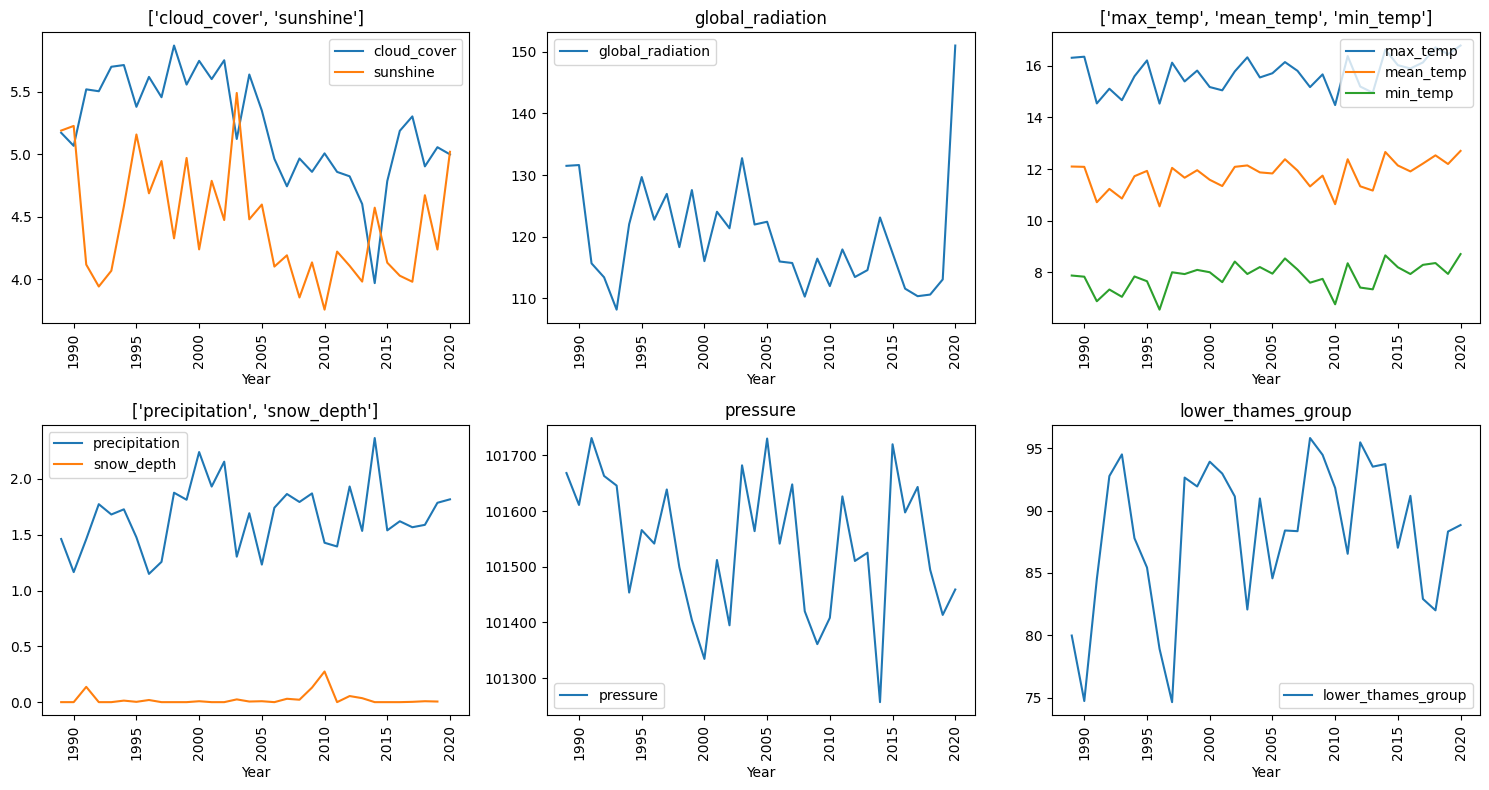

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15,8))
attribute_sets = [['cloud_cover', 'sunshine'], 'global_radiation', ['max_temp', 'mean_temp', 'min_temp'], ['precipitation', 'snow_depth'], 'pressure', 'lower_thames_group']
yearly_means = df.groupby(by='year').mean(numeric_only=True)

for i, attribute_set in enumerate(attribute_sets):
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    ax.plot(yearly_means.index, yearly_means[attribute_set], label=attribute_set)
    ax.tick_params(axis='x', rotation=90)
    ax.set_xlabel('Year')
    ax.set_title(f'{attribute_set}')
    ax.legend()

plt.tight_layout()
plt.show()

**Wnioski na temat średniej zmienności w poszczególnych latach:**
* `cloud_cover` osiągnęło średnio najniższą wartość w roku 2014
* `global_radiation` miało bardzo duży wzrost w roku 2020
* `snow_depth` osiągnęło średnio wyższe wartości w latach 1991 i 2009-2010
* `lower_thames_group` osiągnęło średnio najniższe wartości w latach 1990 i 1997

#### Analiza zmienności na przestrzeni miesięcy

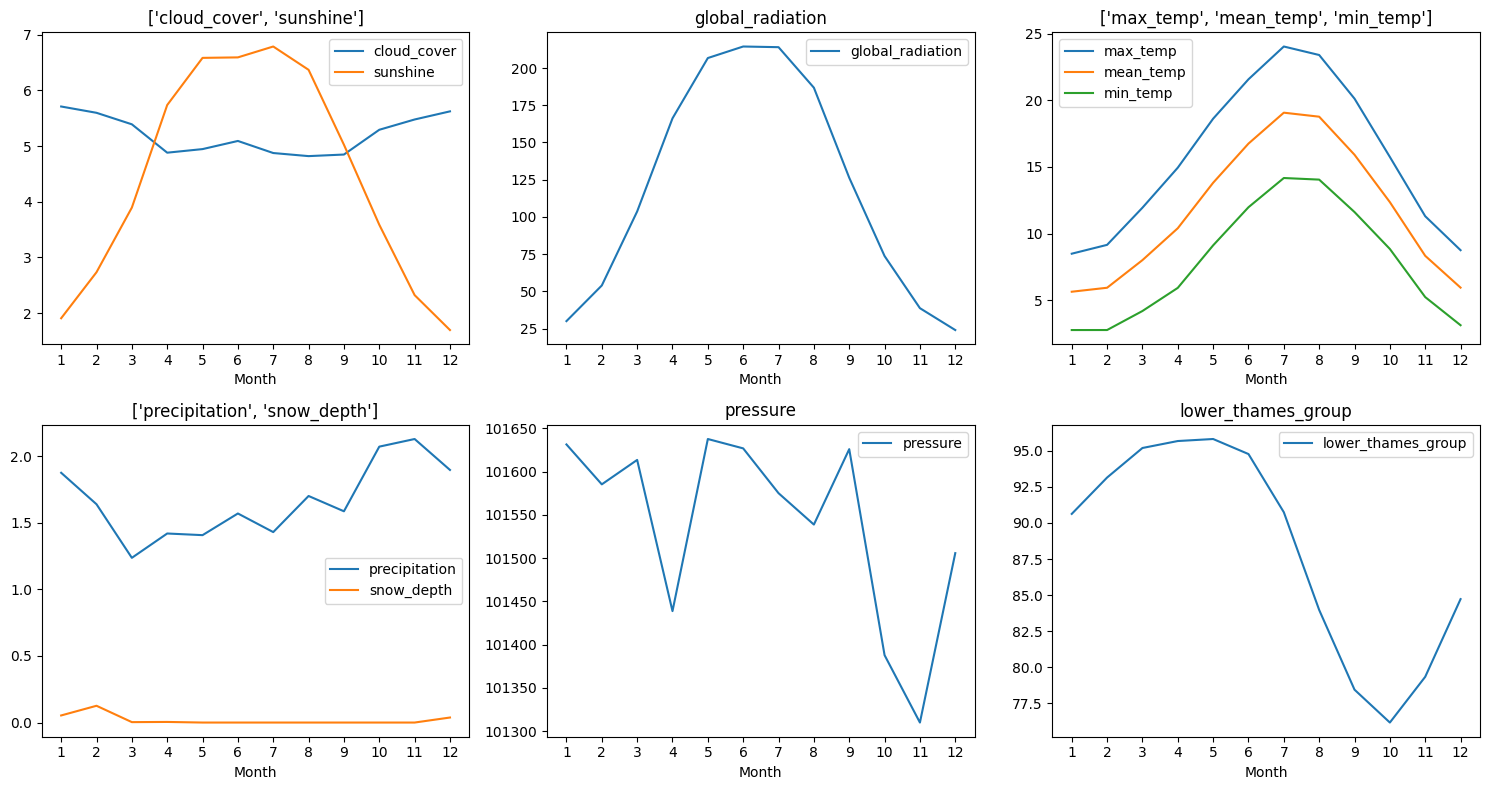

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15,8))
attribute_sets = [['cloud_cover', 'sunshine'], 'global_radiation', ['max_temp', 'mean_temp', 'min_temp'], ['precipitation', 'snow_depth'], 'pressure', 'lower_thames_group']
monthly_means = df.groupby(by='month').mean(numeric_only=True)

for i, attribute_set in enumerate(attribute_sets):
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    ax.plot(monthly_means.index, monthly_means[attribute_set], label=attribute_set)
    ax.set_xticks(monthly_means.index)
    ax.set_xlabel('Month')
    ax.set_title(f'{attribute_set}')
    ax.legend()

plt.tight_layout()
plt.show()

**Wnioski na temat średniej zmienności w poszczególnych miesiącach:**
* `sunshine` przyjmuje najwyższe wartości w okresie kwiecień-wrzesień i najniższe zimą w grudniu i styczniu
* `cloud_cover` przyjmuje wyższe wartości zimą
* `global_radiation` ma zbliżony rozkład do `sunshine` - największe wartości latem, najmniejsze zimą
* `max_temp`, `mean_temp` i `min_temp` przyjmują największe wartości w lipcu, a najmniejsze w styczniu
* `precipitation` jest największe w okresie jesiennym
* `snow_depth` przyjmuje wartości różne od 0 w okresie ok. grudzień-luty, przy czym najwięjksze w lutym
* `pressure` przyjmuje najmniejsze wartości w listopadzie
* `lower_thames_group` przyjmuje najniższe wartości w październiku, a najwyższe w okresie marzec-czerwiec

Wpływ zmiennej `month` na inne zmienne jest charaketystyczny, dlatego w przyszłym etapie przekształcimy `month` do postaci cyklicznej, aby odległość między grudniem a styczniem była taka sama jak pomiędzy dowolnymi innymi sąsiadującymi miesiącami.

### Analiza skośności

In [ ]:
attributes = ['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'mean_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth', 'lower_thames_group']

df[attributes].skew(axis=0, skipna=True)

cloud_cover           -0.663808
sunshine               0.674256
global_radiation       0.652762
max_temp               0.158945
mean_temp              0.018667
min_temp              -0.152425
precipitation          4.434201
pressure              -0.432379
snow_depth            23.759610
lower_thames_group    -1.696334
dtype: float64

**Wnioski na temat skośności:**
* `snow_depth` i `percipitation` - rozkład bardzo prawoskośny
* `sunshine` i `global_radiation` - rozkład umiarkowanie prawoskośny
* `max_temp`, `mean_temp` i `min_temp` - rozkład zbliżony do normalnego
* `cloud_cover`, `pressure` i `lower_thames_group` - rozkład umiarkowanie lewoskośny

### Analiza zależności między atrybutami

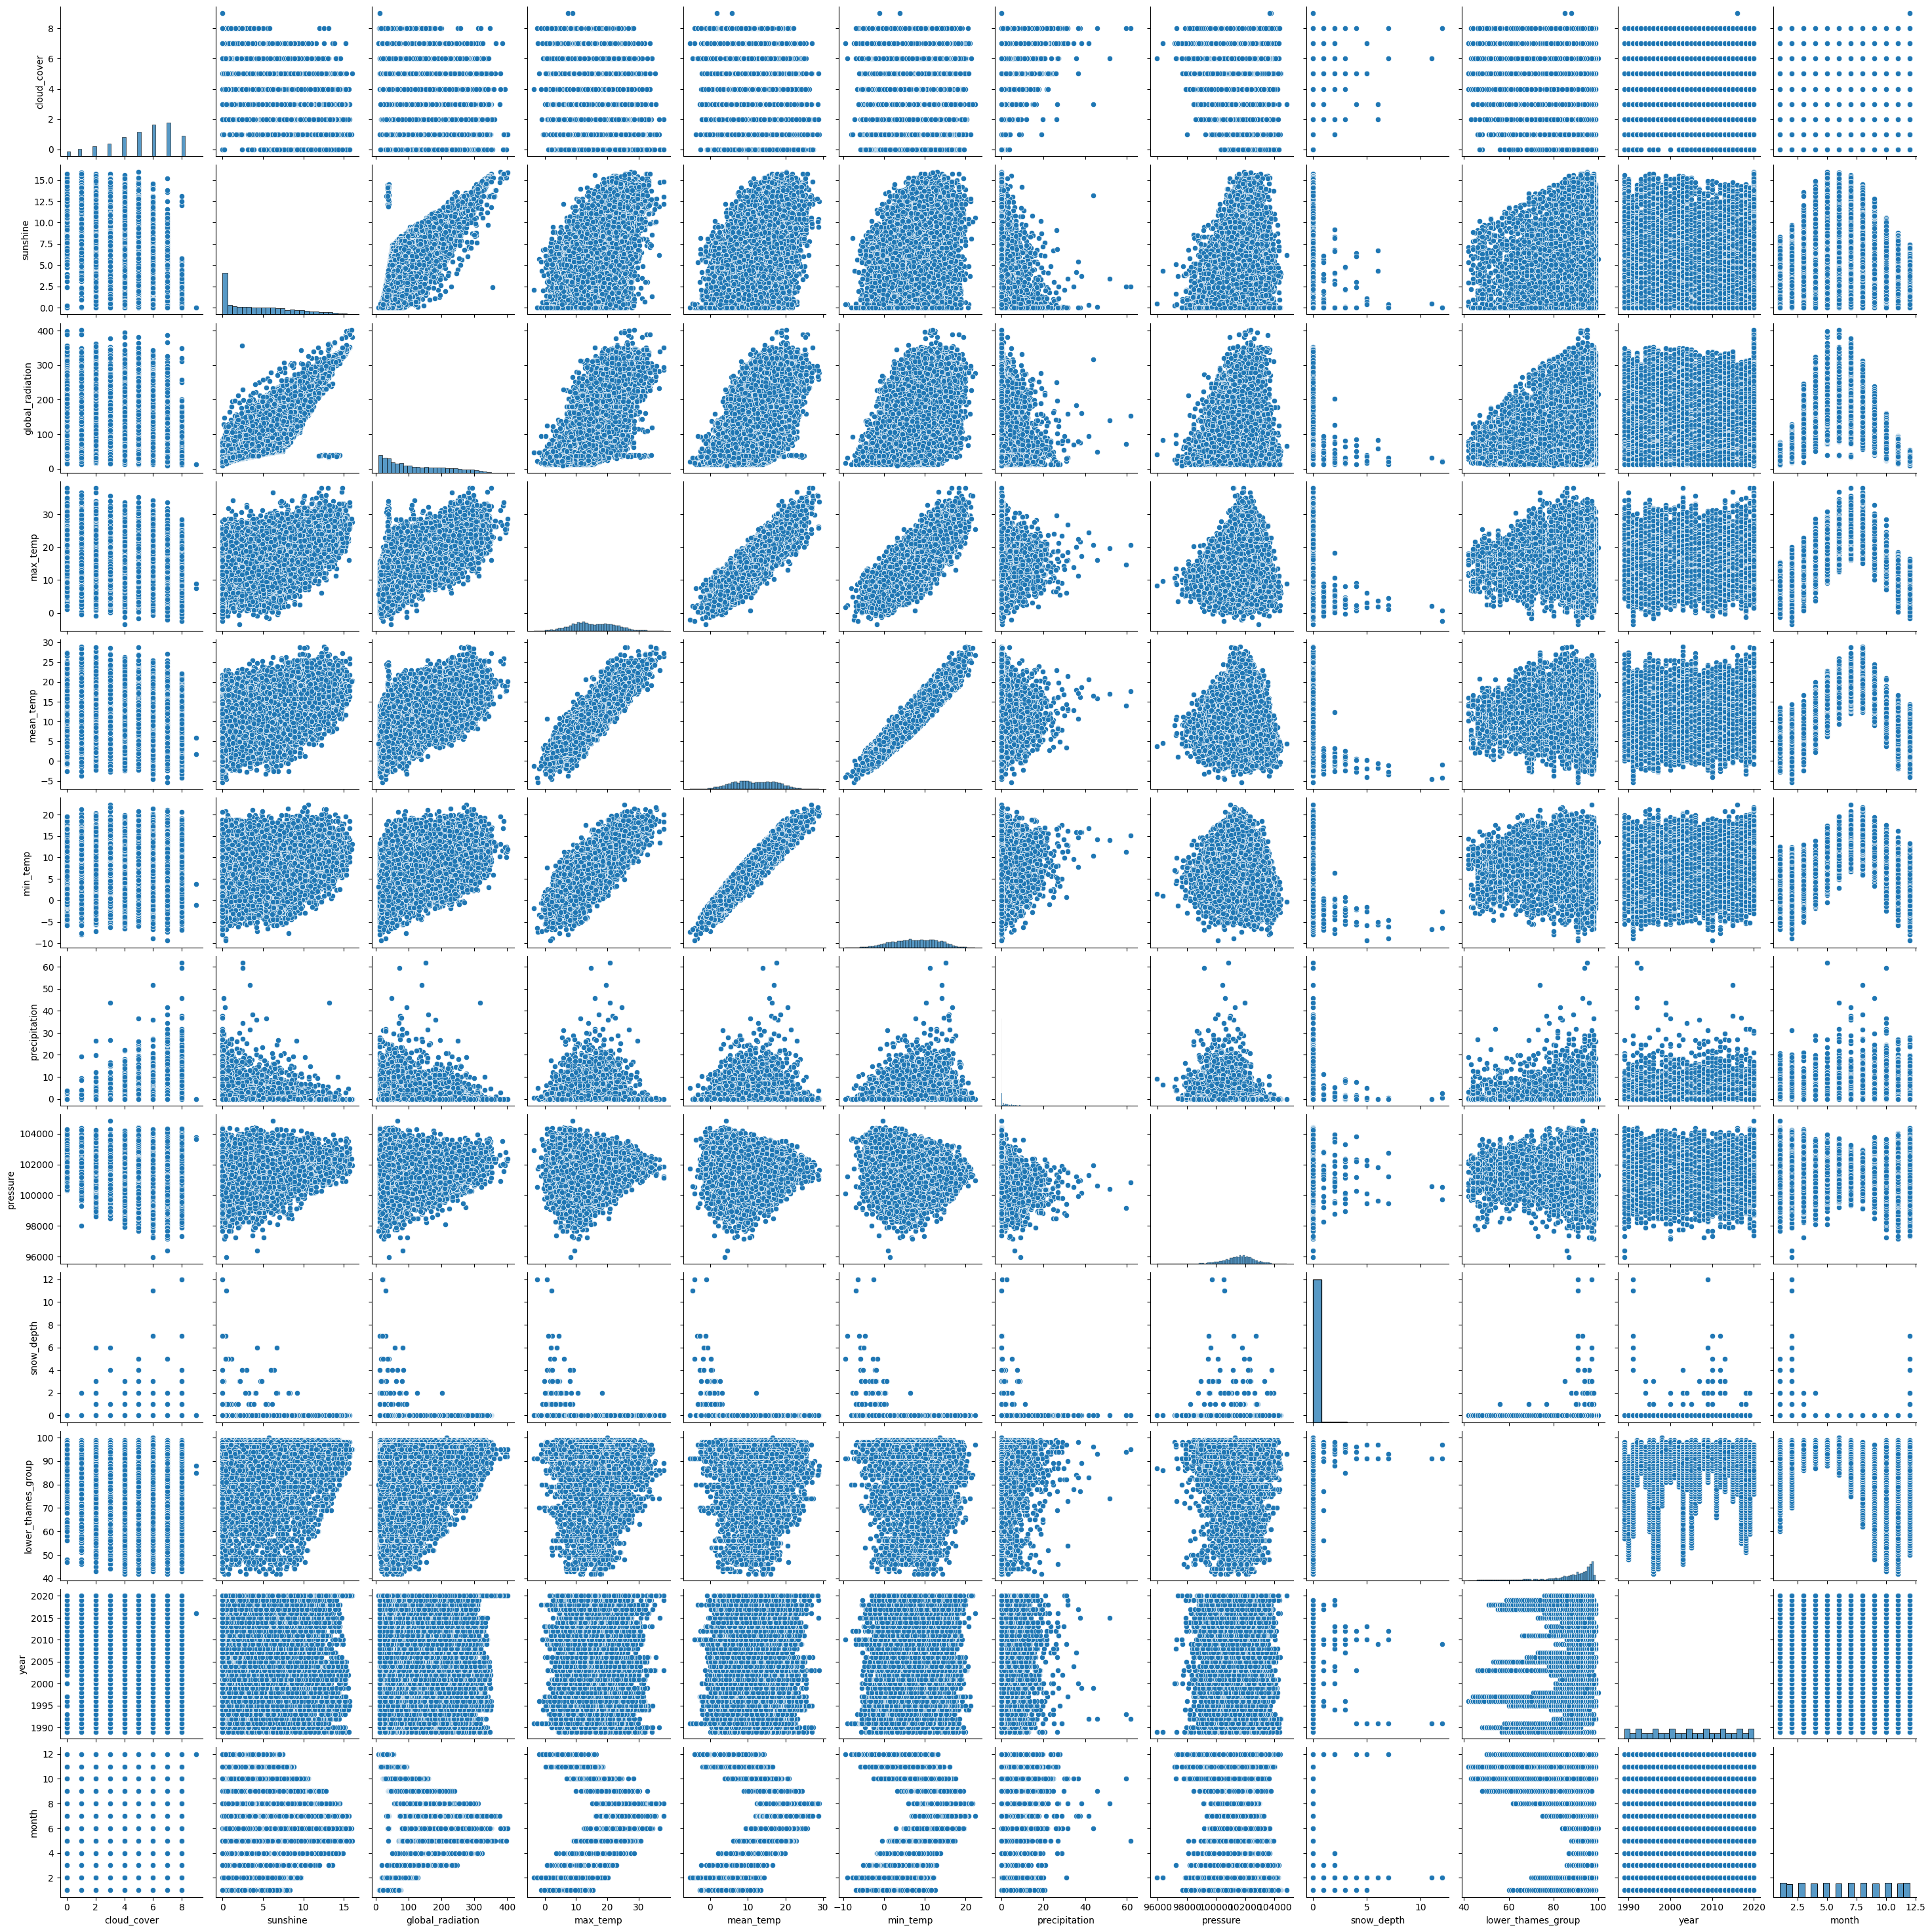

In [ ]:
sns.pairplot(df)

**Wnioski na temat zależności między atrybutami:**
* `sunshine` i `global_radiation`:
  * zależność liniowa pozytywna
  * grupa obiektów odstających o wysokiej wartości `sunshine` i niskiej wartości `global_radiation`
* `max_temp`, `mean_temp` i `min_temp` - zależność liniowa pozytywna:
  * największa dla `mean_temp` i `min_temp`
* charakterystyczny wpływ `month` na inne atrubuty, który był omówiony we wcześniejszej części analizy

<Axes: >

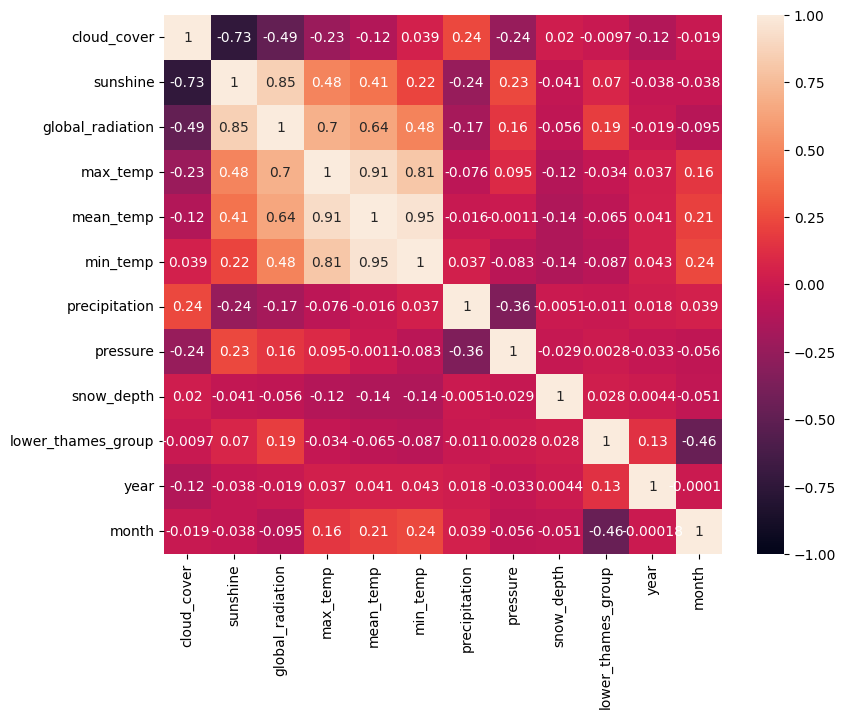

In [ ]:
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(9,7))
sns.heatmap(corr_matrix, annot=corr_matrix, vmin=-1, vmax=1)

In [ ]:
triangle_corr_matrix = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool))
high_corr_features = [(triangle_corr_matrix.index[i], triangle_corr_matrix.columns[j], triangle_corr_matrix.iloc[i,j])
                      for i, j in zip(*np.where(triangle_corr_matrix.abs() > 0.7))]
print('Pary cech skorelowanych > 0.7 (lub < -0.7):')
for feature1, feature2, corr in high_corr_features:
    print(f'{feature1} i {feature2}: {corr}')

Pary cech skorelowanych > 0.7 (lub < -0.7):
sunshine i cloud_cover: -0.7348709200690673
global_radiation i sunshine: 0.852986904055873
mean_temp i max_temp: 0.914107705340264
min_temp i max_temp: 0.8094106472711524
min_temp i mean_temp: 0.9542709814690914


**Wnioski na temat korelacji:**
* wartości współczynników korelacji potwierdzają zauważone wcześniej zależności na wykresach punktowych
* 5 par atrybutów jest silnie skorelowanych (współczynnik korelacji > 0.7 lub < -0.7)
* `sunshine` i `cloud_cover` (silna korelacja ujemna) - im większe zachmurzenie, tym mniejsze usłonecznienie
* `global_radiation` i `sunshine` (silna korelacja dodatnia) - im większe usłonecznienie, tym większe natężenie napromieniowania
* `min_temp`, `mean_temp`, `max_temp` (silna korelacja dodatnia) - wszystkie 3 atrybuty dotyczą temperatury w ciągu dnia, co sprawia, że są silnie od siebie zależne

### Braki w danych

In [ ]:
df.isna().sum()

cloud_cover              6
sunshine                 0
global_radiation        19
max_temp                 6
mean_temp               36
min_temp                 2
precipitation            6
pressure                 3
snow_depth            1441
lower_thames_group      13
year                     0
month                    0
dtype: int64

Jedynie dla atrybutu `snow_depth` występuje znacząca liczba braków. W pozostałych atrybutach występują niewielkie braki.

Zbadamy, czy braki dla atrybutu `snow_depth` występują losowo czy według jakiejś zależności.

In [ ]:
df_snow_depth_missing = df[df['snow_depth'].isna()]

In [ ]:
df_snow_depth_missing['year'].value_counts(sort=False)

2005      2
2006    180
2007    166
2008    181
2009    181
2010    183
2011    180
2015      2
2020    366
Name: year, dtype: int64

Braki w `snow_depth`:
* 2020 - brak wszystkich danych
* 2006-2011 - brak ok. 1/3 danych
* 2005, 2015 - pojedyncze braki

In [ ]:
for y in range(2006, 2012):
  print(f'Year {y}')
  print(df[(df['year'] == y) & (df['snow_depth'].isna())]['month'].value_counts(sort=False))

Year 2006
1      1
3      1
4      1
5     22
6     30
7     31
8     31
9     30
10    27
11     2
12     4
Name: month, dtype: int64
Year 2007
1      1
2      3
4      2
5     17
6     30
7     31
8     31
9     30
10    19
11     1
12     1
Name: month, dtype: int64
Year 2008
1      1
2      3
3      1
4      1
5     31
6     30
7     31
8     31
9     30
10    21
11     1
Name: month, dtype: int64
Year 2009
2      3
4     23
5     31
6     30
7     31
8     31
9     30
10     1
12     1
Name: month, dtype: int64
Year 2010
4      4
5     31
6     30
7     31
8     31
9     30
10    25
12     1
Name: month, dtype: int64
Year 2011
1      2
4     18
5     31
6     30
7     31
8     31
9     30
10     7
Name: month, dtype: int64


Braki w latach 2006-2011 występują (oprócz pojedynczych innych) w miesiącach od kwietnia lub maja do września lub października. We wszystkich z tych lat brakuje danych dla pełnych miesięcy od czerwca do września. Są to okresy, w których typowo nie pada śnieg, więc można założyć, że `snow_depth` powinien wynosić tu 0.

### Hipoteza badawcza

> *Jaki wpływ na procent użytkowej pojemności wody w rezerwuarach 'Grupy Dolnej Tamizy' mają warunki pogodowe w Londynie i okres ich pomiarów?*

Atrybuty opisujące:
* `cloud_cover` - zachmurzenie [okta]
* `sunshine` - usłonecznienie [godz.]
* `global_radiation` - natężenie napromieniowania [W/m^2]
* `max_temp` - maksymalna temperatura [°C]
* `mean_temp` - średnia temperatura [°C]
* `min_temp` - minimalna temperatura [°C]
* `predipitation` - opad atmosferyczny [mm]
* `pressure` - ciśnienie atmosferyczne [Pa]
* `snow_depth` - głębokość pokrywy śnieżnej [cm]
* `year` - rok przeprowadzenia pomiaru
* `month` - miesiąc przeprowadzenia pomiaru

Atrybut decyzyjny: `lower_thames_group` - procent użytkowej pojemności wody w rezerwuarach 'Grupy Dolnej Tamizy'

Opracujemy model regresji przewidujący atrybut decyzyjny `lower_thames_group` na podstawie atrybutów opisujących przedstawionych powyżej.

In [ ]:
df.to_csv(eda_csv_file, index=False)



---



## Opracowanie modeli regresji
Po przygotowaniu zbioru danych opracujemy następujące modele regresji:
* z cechami z oryginalnego zbioru danych:
    * regresja wieloraka bez regularyzacji
    * regresja grzbietowa (L2)
    * regresja Lasso (L1)
* z dodanymi nowo utworzonymi cechami na podstawie przekształceń cech z oryginalego zbioru danych:
    * regresja wieloraka bez regularyzacji
    * regresja grzbietowa (L2)
    * regresja Lasso (L1)
* z automatycznym doborem cech:
    * regresja krokowa w przód:
        * regresja wieloraka bez regularyzacji
        * regresja grzbietowa (L2)
        * regresja Lasso (L1)
    * regresja krokowa w tył:
        * regresja wieloraka bez regularyzacji
        * regresja grzbietowa (L2)
        * regresja Lasso (L1)

### Przygotowanie zbioru danych

In [ ]:
df = pd.read_csv(eda_csv_file)
df.head()

cloud_cover  sunshine  global_radiation  max_temp  mean_temp  min_temp  \
0          7.0       0.0              13.0       8.2        7.4       6.6   
1          6.0       0.0              13.0       9.5        7.1       6.0   
2          8.0       0.0              13.0      11.2        6.2       3.0   
3          5.0       3.8              39.0      11.1        8.0       4.8   
4          5.0       0.0              13.0      10.7        6.2       1.2   

   precipitation  pressure  snow_depth  lower_thames_group  year  month  
0            0.0  103870.0         0.0                76.0  1989      1  
1            0.0  103550.0         0.0                75.0  1989      1  
2            0.4  102950.0         0.0                75.0  1989      1  
3            0.0  102530.0         0.0                75.0  1989      1  
4            3.7  102340.0         0.0                75.0  1989      1

#### Imputacja danych

In [ ]:
df.isna().sum()

cloud_cover              6
sunshine                 0
global_radiation        19
max_temp                 6
mean_temp               36
min_temp                 2
precipitation            6
pressure                 3
snow_depth            1441
lower_thames_group      13
year                     0
month                    0
dtype: int64

In [ ]:
df.dropna(subset=['lower_thames_group'], inplace=True)

In [ ]:
df['cloud_cover'].fillna(df['cloud_cover'].median(), inplace=True)

In [ ]:
attributes = ['global_radiation', 'max_temp', 'mean_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth']
month_groups = df.groupby('month')

for atr in attributes:
  df[atr] = month_groups[atr].transform(lambda x: x.fillna(x.mean()))

In [ ]:
df.isna().sum()

cloud_cover           0
sunshine              0
global_radiation      0
max_temp              0
mean_temp             0
min_temp              0
precipitation         0
pressure              0
snow_depth            0
lower_thames_group    0
year                  0
month                 0
dtype: int64

Postępowanie przy brakach danych:
* `lower_thames_group` - usunięcie braków, ponieważ to zmienna celu
* `cloud_cover` - zastąpienie braków medianą, ponieważ to zmienna przyjmująca tylko wartości całkowite
* reszta cech - zastąpienie braków średnią dla poszczególnych miesięcy, aby zachować zależność między miesiącem a warunkami pogodowymi

#### Utworzenie nowych cech

In [ ]:
original_atr = ['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'mean_temp',
                'min_temp', 'precipitation', 'pressure', 'snow_depth', 'year', 'month']

In [ ]:
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

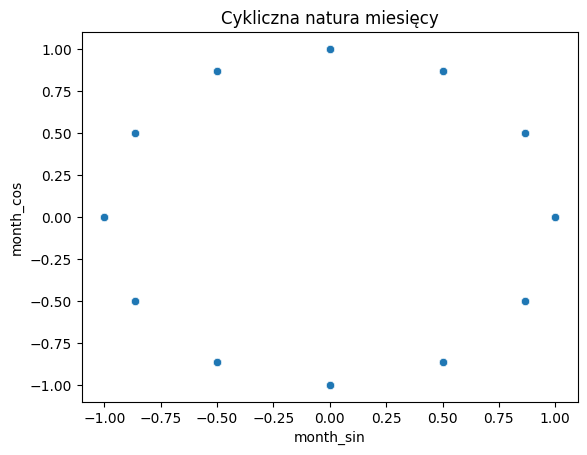

In [ ]:
sns.scatterplot(x=df['month_sin'], y=df['month_cos'])
plt.title('Cykliczna natura miesięcy')
plt.show()

Ze względu na cykliczną naturę miesięcy, przekształciłyśmy `month` do postaci 2 składowych: `month_sin` i `month_cos`. Dzięki temu odległość między sąsiadującymi miesiącami jest taka sama. Jest to istotne dla stycznia i grudnia, które przy originalnym kodowaniu były oddalone od siebie najbardziej.

In [ ]:
df['log_sunshine'] = df['sunshine'].apply(lambda x: np.log1p(x))
df['log_global_radiation'] = df['global_radiation'].apply(lambda x: np.log1p(x))
df['log_precipitation'] = df['precipitation'].apply(lambda x: np.log1p(x))
df['log_snow_depth'] = df['snow_depth'].apply(lambda x: np.log1p(x))

W celu redukcji prawoskośności rozkładów dodano następujące cechy:
* `log_sunshine`
* `log_global_radiation`
* `log_precipitation`
* `log_snow_depth`

Ponieważ wiele obserwacji przyjmowało wartość 0 dla tych cech, zastosowano przekształcenie $log(x+1)$ zamiast $log(x)$.

In [ ]:
all_atr = ['cloud_cover', 'sunshine', 'global_radiation', 'max_temp',
          'mean_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth',
          'year', 'month', 'month_sin', 'month_cos', 'log_sunshine',
          'log_global_radiation', 'log_precipitation', 'log_snow_depth']

#### Podział na zbiór uczący i testowy

In [ ]:
random_state = 1
y = df['lower_thames_group']
df.drop('lower_thames_group', axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=random_state)

In [ ]:
print(f'Wielkość zbioru uczącego = {len(y_train)}')
print(f'Wielkość zbioru testowego = {len(y_test)}')

Wielkość zbioru uczącego = 8172
Wielkość zbioru testowego = 3503


Podzielono dane na zbiór uczący i testowy w proporcji 7:3.

#### Standaryzacja

In [ ]:
X_train_mean = np.mean(X_train, axis=0)
X_train_std = np.std(X_train, axis=0)
X_train = ((X_train - X_train_mean) / X_train_std)
X_test = ((X_test - X_train_mean) / X_train_std)

Aby możliwe było porównanie ważności cech, zostały one ustandaryzowane za pomocą parametrów ze zbioru uczącego.

### Funkcje pomocnicze

In [ ]:
# funkcja wyświetlająca ranking ważności zmiennych
def print_coefs(atrributes, coefs):
    print("Coefficients:")
    features_and_coefs = list(zip(atrributes, coefs))
    sorted_features = sorted(features_and_coefs, key=lambda x: abs(x[1]), reverse=True)
    for feature, coef in sorted_features:
        print(f"{feature}: {coef}")
    return sorted_features

In [ ]:
# funkcja ucząca i testująca model regresji wielorakiej
def linear_regression(X_train, X_test, y_train, y_test):
    regressor = LinearRegression()

    regressor.fit(X_train, y_train)

    y_pred_train = regressor.predict(X_train)
    y_pred_test = regressor.predict(X_test)

    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    return mse_train, mse_test, regressor.coef_

In [ ]:
# funkcja dobierająca optymalną wartość współczynnika regularyzacji dla regresji grzebietowej
def ridge_find_alpha(X_train, y_train, alphas):
    mse_train = []
    mse_val = []

    for a in alphas:
        ridge = Ridge(alpha=a)

        cross_val_mse = -cross_val_score(ridge, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        mse_val.append(cross_val_mse.mean())

        ridge.fit(X_train, y_train)
        y_pred_train = ridge.predict(X_train)

        mse_train.append(mean_squared_error(y_train, y_pred_train))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(alphas, mse_train, '*-')
    plt.title('Zależność MSE uczenia od wartości parametru regularyzacji')
    plt.xlabel('alpha')
    plt.ylabel('MSE')

    plt.subplot(1, 2, 2)
    plt.plot(alphas, mse_val, '*-')
    plt.title('Zależność MSE walidacji od wartości parametru regularyzacji')
    plt.xlabel('alpha')
    plt.ylabel('MSE')

    plt.tight_layout()
    plt.show()

    return alphas[np.argmin(mse_val)]

In [ ]:
# funkcja ucząca i testująca model regresji grzbietowej
def ridge_regression(X_train, X_test, y_train, y_test, alpha):
    ridge = Ridge(alpha=alpha)

    ridge.fit(X_train, y_train)

    y_pred_train = ridge.predict(X_train)
    y_pred_test = ridge.predict(X_test)

    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    return mse_train, mse_test, ridge.coef_

In [ ]:
# funkcja dobierająca optymalną wartość współczynnika regularyzacji dla regresji Lasso
def lasso_find_alpha(X_train, y_train, alphas):
    mse_train = []
    mse_val = []

    for a in alphas:
        lasso = Lasso(alpha=a)

        cross_val_mse = -cross_val_score(lasso, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        mse_val.append(cross_val_mse.mean())

        lasso.fit(X_train, y_train)
        y_pred_train = lasso.predict(X_train)

        mse_train.append(mean_squared_error(y_train, y_pred_train))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(alphas, mse_train, '*-')
    plt.title('Zależność MSE uczenia od wartości parametru regularyzacji')
    plt.xlabel('alpha')
    plt.ylabel('MSE')

    plt.subplot(1, 2, 2)
    plt.plot(alphas, mse_val, '*-')
    plt.title('Zależność MSE walidacji od wartości parametru regularyzacji')
    plt.xlabel('alpha')
    plt.ylabel('MSE')

    plt.tight_layout()
    plt.show()

    return alphas[np.argmin(mse_val)]

In [ ]:
# funkcja ucząca i testująca model regresji Lasso
def lasso_regression(X_train, X_test, y_train, y_test, alpha):
    lasso = Lasso(alpha=alpha)

    lasso.fit(X_train, y_train)

    y_pred_train = lasso.predict(X_train)
    y_pred_test = lasso.predict(X_test)

    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    return mse_train, mse_test, lasso.coef_

### Modele regresji dla cech z oryginalnego zbioru

#### Regresja wieloraka bez regularyzacji

In [ ]:
mse_train1, mse_test1, coefs = linear_regression(X_train[original_atr], X_test[original_atr], y_train, y_test)

print(f'MSE train: {mse_train1}')
print(f'MSE test: {mse_test1}\n')

coefs1 = print_coefs(original_atr, coefs)

MSE train: 94.97428229339354
MSE test: 90.24423750376052

Coefficients:
global_radiation: 8.527805762649944
sunshine: -4.95553032461915
mean_temp: -4.893001895519534
month: -4.138087337007031
min_temp: 2.0564679037863645
year: 1.592483486575121
max_temp: -0.6617896577347735
cloud_cover: -0.3604742403564677
precipitation: 0.15649131356936086
snow_depth: -0.08060192943315117
pressure: -0.05519484858947454


**Wnioski:**
* błąd testowy jest mniejszy niż błąd uczący
* największy wpływ miała zmienna `global_radiation`
* najmniejszy wpływ miała zmienna `pressure`

#### Regresja grzbietowa (L2)

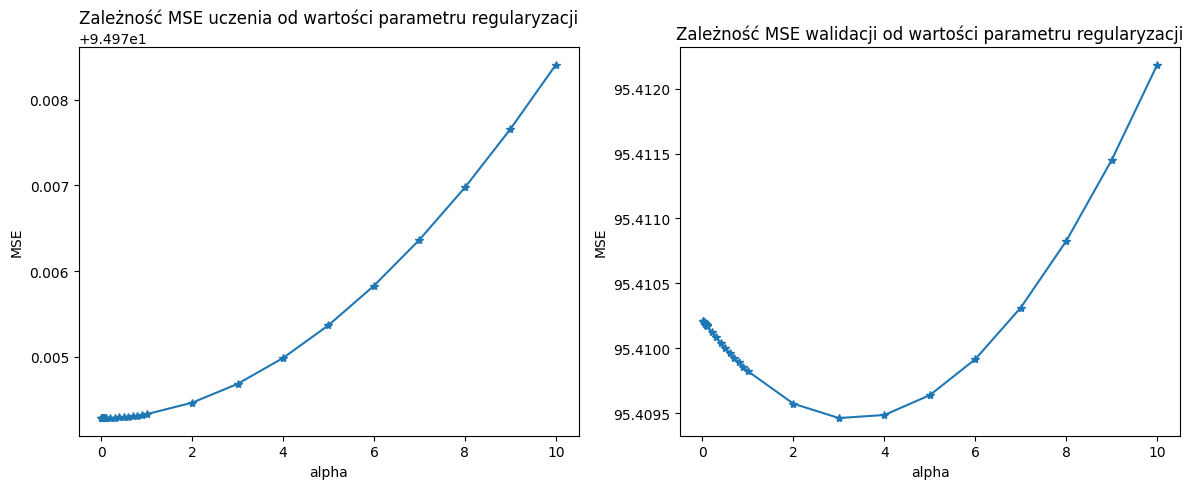

Optimal alpha = 3


In [ ]:
alphas = [i * val for val in [0.01, 0.1, 1] for i in range(1, 10)] + [10]
optimal_alpha = ridge_find_alpha(X_train[original_atr], y_train, alphas)
print(f'Optimal alpha = {optimal_alpha}')

Optymalną wartością współczynnika regularyzacji, która minimalizuje błąd walidacji jest $\alpha = 3$.

In [ ]:
mse_train2, mse_test2, coefs = ridge_regression(X_train[original_atr], X_test[original_atr], y_train, y_test, optimal_alpha)

print(f'MSE train: {mse_train2}')
print(f'MSE test: {mse_test2}\n')

coefs2 = print_coefs(original_atr, coefs)

MSE train: 94.97468074054191
MSE test: 90.22381196783351

Coefficients:
global_radiation: 8.486042802810081
sunshine: -4.925123155373479
mean_temp: -4.795334580750383
month: -4.141102609217557
min_temp: 1.9894896872899444
year: 1.5932313211820561
max_temp: -0.6783599380863282
cloud_cover: -0.347561052056692
precipitation: 0.1559248377838113
snow_depth: -0.07993146117408423
pressure: -0.05699517410333117


**Wnioski:**
* błąd testowy jest mniejszy niż błąd uczący
* wartości obydwu błędów są niemalże identyczne jak dla regresji bez regularyzacji:
    * błąd uczenia - minimalnie większy
    * błąd testowy - minimalnie mniejszy
* największy wpływ miała zmienna `global_radiation`
* najmniejszy wpływ miała zmienna `pressure`

#### Regresja Lasso (L1)

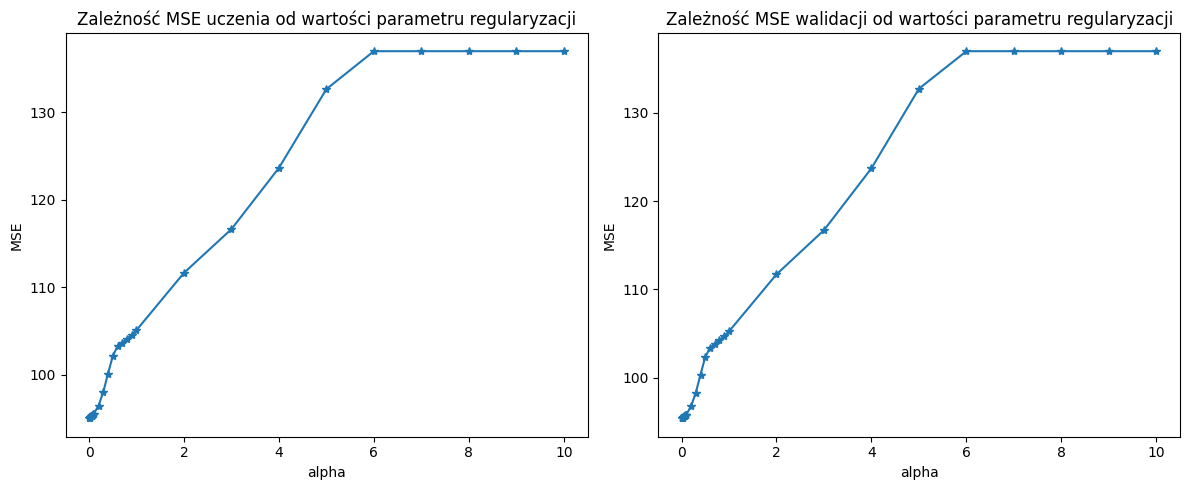

Optimal alpha = 0.01


In [ ]:
# ten do zapisu
alphas = [i * val for val in [0.01, 0.1, 1] for i in range(1, 10)] + [10]
optimal_alpha = lasso_find_alpha(X_train[original_atr], y_train, alphas)
print(f'Optimal alpha = {optimal_alpha}')

Pierwsze poszukiwanie optymalnej wartości współczynnika regularyzacji zakończyło się niepowodzeniem - algorytm wybrał po prostu najmniejszą wartość $\alpha$. Należy zawęzić obszar poszukiwań.

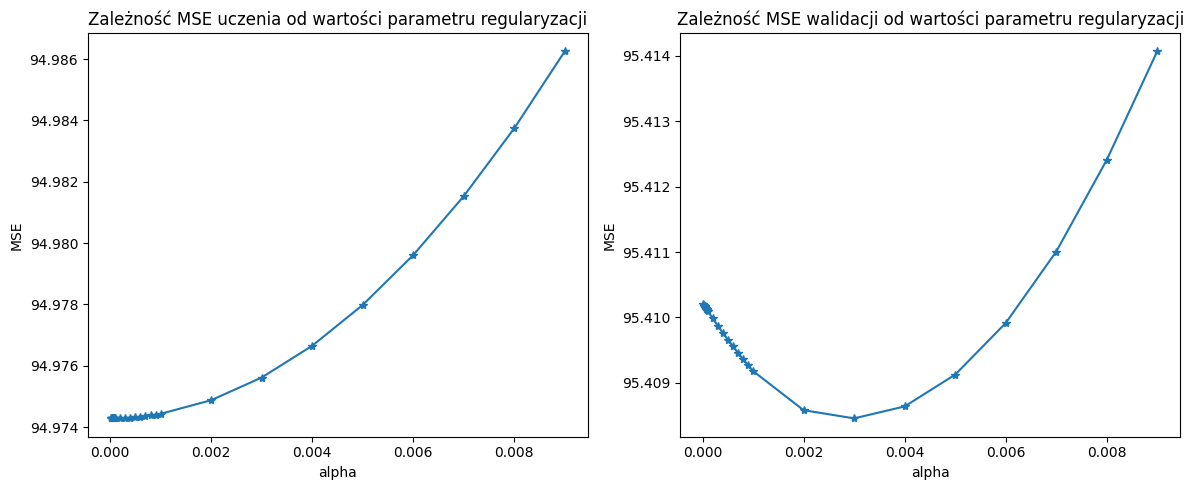

Optimal alpha = 0.003


In [ ]:
# ten do zapisu
alphas = [i * val for val in [0.00001, 0.0001, 0.001] for i in range(1, 10)]
optimal_alpha = lasso_find_alpha(X_train[original_atr], y_train, alphas)
print(f'Optimal alpha = {optimal_alpha}')

Po zawężeniu obszaru poszukiwań znaleziono optymalną wartością współczynnika regularyzacji, która minimalizuje błąd walidacji jako $\alpha = 0.003$.

In [ ]:
mse_train3, mse_test3, coefs = lasso_regression(X_train[original_atr], X_test[original_atr], y_train, y_test, optimal_alpha)

print(f'MSE train: {mse_train3}')
print(f'MSE test: {mse_test3}\n')

coefs3 = print_coefs(original_atr, coefs)

MSE train: 94.97561466537475
MSE test: 90.21001041912395

Coefficients:
global_radiation: 8.46585059971225
sunshine: -4.911208996704667
mean_temp: -4.710645971682602
month: -4.140190327394154
min_temp: 1.9162589313261256
year: 1.5927264534133492
max_temp: -0.6825191007978226
cloud_cover: -0.33115739000222827
precipitation: 0.15292388801777446
snow_depth: -0.07683718042534089
pressure: -0.05682637984397786


**Wnioski:**
* błąd testowy jest mniejszy niż błąd uczący
* wartości obydwu błędów są niemalże identyczne jak dla regresji bez regularyzacji:
    * błąd uczenia - minimalnie większy
    * błąd testowy - minimalnie mniejszy
* największy wpływ miała zmienna `global_radiation`
* najmniejszy wpływ miała zmienna `pressure`

### Modele regresji dla wszystkich cech (wraz z nowymi)

#### Regresja wieloraka bez regularyzacji

In [ ]:
mse_train4, mse_test4, coefs = linear_regression(X_train, X_test, y_train, y_test)

print(f'MSE train: {mse_train4}')
print(f'MSE test: {mse_test4}\n')

coefs4 = print_coefs(all_atr, coefs)

MSE train: 85.44223073892928
MSE test: 79.93826931472876

Coefficients:
log_global_radiation: -5.379542469645451
month_cos: -5.3362558576024215
month_sin: 4.4511397487462965
global_radiation: 4.2344260249910315
mean_temp: -3.193550073591582
log_sunshine: 2.8025002967161536
sunshine: -2.8002698392463223
min_temp: 2.313542672122439
year: 1.4790442151884977
month: -1.0083562736195806
cloud_cover: -0.6244650867144534
log_snow_depth: 0.4315051922319696
snow_depth: -0.3366508513039794
max_temp: -0.25597260651001275
precipitation: 0.12331066951525944
log_precipitation: 0.04924566310936258
pressure: -0.0038099269468465364


**Wnioski:**
* zmniejszenie wartości obydwu błędów
* błąd testowy jest mniejszy niż błąd uczący
* największy wpływ miała zmienna z nowych cech `log_global_radiation`
* najmniejszy wpływ miała zmienna `pressure`
* duży wpływ z nowych cech miały:
    * `log_global_radiation`
    * `month_cos`
    * `month_sin`
    * `log_sunshine`
* ponieważ model zawiera więcej cech, wielkości wartości współczynników dla poszczególnych zmiennych się zmniejszyły

#### Regresja grzbietowa (L2)

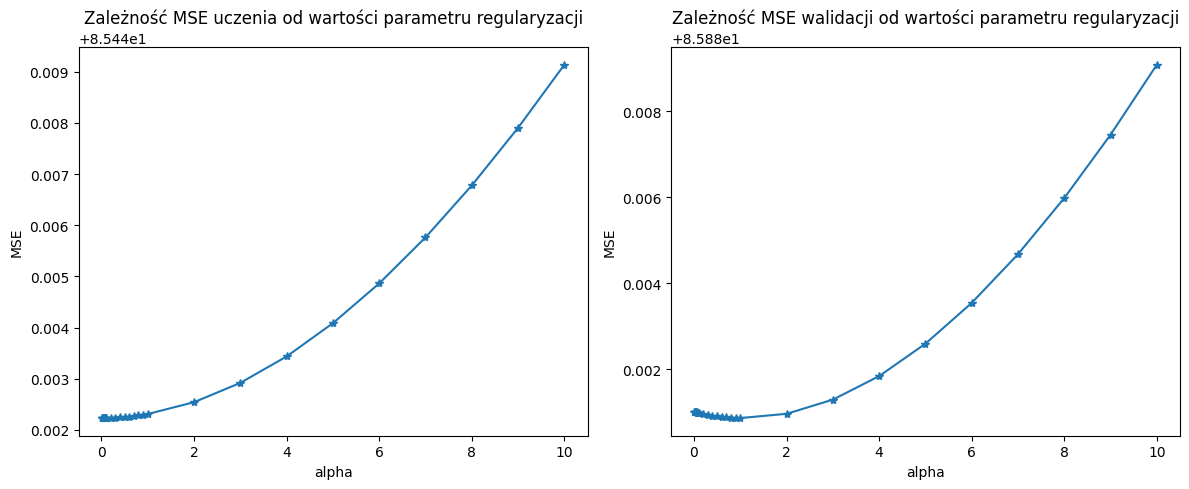

Optimal alpha = 1


In [ ]:
alphas = [i * val for val in [0.01, 0.1, 1] for i in range(1, 10)] + [10]
optimal_alpha = ridge_find_alpha(X_train, y_train, alphas)
print(f'Optimal alpha = {optimal_alpha}')

Optymalną wartością współczynnika regularyzacji, która minimalizuje błąd walidacji jest $\alpha = 1$.

In [ ]:
mse_train5, mse_test5, coefs = ridge_regression(X_train, X_test, y_train, y_test, optimal_alpha)

print(f'MSE train: {mse_train5}')
print(f'MSE test: {mse_test5}\n')

coefs5 = print_coefs(all_atr, coefs)

MSE train: 85.44230940091121
MSE test: 79.9398918848029

Coefficients:
log_global_radiation: -5.342040304911312
month_cos: -5.322106787183062
month_sin: 4.452927894297801
global_radiation: 4.2143633405505945
mean_temp: -3.165517944641579
sunshine: -2.7764564099274587
log_sunshine: 2.7704465733928507
min_temp: 2.2936066182950756
year: 1.4792920433245704
month: -1.0069422373619803
cloud_cover: -0.6212921159480701
log_snow_depth: 0.4315182676891227
snow_depth: -0.33637862516970096
max_temp: -0.2633361937866858
precipitation: 0.12311798151644196
log_precipitation: 0.04888061307821169
pressure: -0.004462372802466971


**Wnioski:**
* błąd testowy jest mniejszy niż błąd uczący
* wartości obydwu błędów są niemalże identyczne jak dla regresji bez regularyzacji:
    * błąd testowy - minimalnie większy
* największy wpływ miała zmienna `log_global_radiation`
* najmniejszy wpływ miała zmienna `pressure`
* regularyzacja L2 nie poprawia efektywności modelu

#### Regresja Lasso (L1)

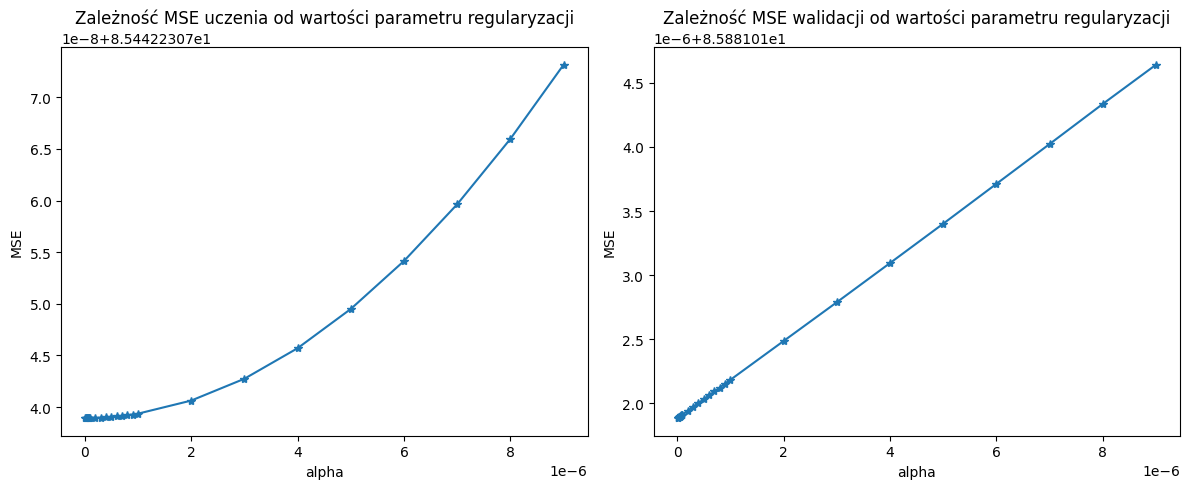

Optimal alpha = 1e-08


In [ ]:
alphas = [i * val for val in [0.00000001, 0.0000001, 0.000001] for i in range(1, 10)]
optimal_alpha = lasso_find_alpha(X_train, y_train, alphas)
print(f'Optimal alpha = {optimal_alpha}')

Błąd walidacji rośnie niezależnie od badanego zakresu poszukiwań współczynnika regularyzacji. Wybrana jest najmniejsza badana wartość $\alpha = 10^{-8}$.

In [ ]:
mse_train6, mse_test6, coefs = lasso_regression(X_train, X_test, y_train, y_test, optimal_alpha)

print(f'MSE train: {mse_train6}')
print(f'MSE test: {mse_test6}\n')

coefs6 = print_coefs(all_atr, coefs)

MSE train: 85.44223073892933
MSE test: 79.93826933887982

Coefficients:
log_global_radiation: -5.379541735874277
month_cos: -5.336255617732855
month_sin: 4.451139804700853
global_radiation: 4.2344255295984
mean_temp: -3.1935493913128536
log_sunshine: 2.802499626312462
sunshine: -2.8002692597033385
min_temp: 2.313542148388799
year: 1.4790442222515117
month: -1.0083562202291967
cloud_cover: -0.624464981012907
log_snow_depth: 0.43150504516306953
snow_depth: -0.3366506987139017
max_temp: -0.25597273499596446
precipitation: 0.12331065961979937
log_precipitation: 0.04924565056516471
pressure: -0.003809939137717275


**Wnioski:**
* błąd testowy jest mniejszy niż błąd uczący
* wartości obydwu błędów są niemalże identyczne jak dla regresji bez regularyzacji
* największy wpływ miała zmienna `log_global_radiation`
* najmniejszy wpływ miała zmienna `pressure`
* regularyzacja L1 nie poprawia efektywności modelu

### Modele regresji z automatycznym doborem cech

#### Regresja krokowa w przód

In [ ]:
lr = LinearRegression()

forward_chosen_features = []
min_err = float('inf')

while len(forward_chosen_features) < len(all_atr):
    remaining_features = list(set(all_atr) - set(forward_chosen_features))
    best_feature_to_add = None

    for feature in remaining_features:
        tmp_features = forward_chosen_features + [feature]
        error = np.mean(-cross_val_score(lr, X_train[tmp_features], y_train, cv=5, scoring='neg_mean_squared_error'))

        if error < min_err:
            min_err = error
            best_feature_to_add = feature

    if best_feature_to_add:
        forward_chosen_features.append(best_feature_to_add)
        print(f'Adding feature: {best_feature_to_add}, err = {min_err}')
    else:
        break

print(f'\nChosen features: {forward_chosen_features}, err = {min_err}')

Adding feature: month_sin, err = 102.24678514291622
Adding feature: month_cos, err = 90.135165265544
Adding feature: year, err = 87.82377825709044
Adding feature: log_global_radiation, err = 87.42068203133147
Adding feature: global_radiation, err = 86.95360596649782
Adding feature: max_temp, err = 86.6326865012716
Adding feature: month, err = 86.46539681649456
Adding feature: log_sunshine, err = 86.37702245891991
Adding feature: sunshine, err = 86.09579413615556
Adding feature: cloud_cover, err = 86.04790755450999
Adding feature: precipitation, err = 86.03641921798337
Adding feature: min_temp, err = 86.0330393058463
Adding feature: mean_temp, err = 85.80699070309261

Chosen features: ['month_sin', 'month_cos', 'year', 'log_global_radiation', 'global_radiation', 'max_temp', 'month', 'log_sunshine', 'sunshine', 'cloud_cover', 'precipitation', 'min_temp', 'mean_temp'], err = 85.80699070309261


In [ ]:
list(set(all_atr) - set(forward_chosen_features))

['pressure', 'log_precipitation', 'log_snow_depth', 'snow_depth']

**Wnioski - regresja krokowa w przód:**
* wybór 13 z 17 cech
* odrzucone cechy miały niskie wartości współczynników dla badanych wcześniej modeli
* cechami najbardziej minimalizującymi błąd były cechy związane z okresem pomiarów

##### Regresja wieloraka bez regularyzacji

In [ ]:
mse_train7, mse_test7, coefs = linear_regression(X_train[forward_chosen_features], X_test[forward_chosen_features], y_train, y_test)

print(f'MSE train: {mse_train7}')
print(f'MSE test: {mse_test7}\n')

coefs7 = print_coefs(forward_chosen_features, coefs)

MSE train: 85.46866201956266
MSE test: 79.94454340422342

Coefficients:
log_global_radiation: -5.414198834047369
month_cos: -5.355689074552276
month_sin: 4.425988025525519
global_radiation: 4.263433392126232
mean_temp: -3.222204064367337
log_sunshine: 2.817341432257135
sunshine: -2.813938293759753
min_temp: 2.3057940472485563
year: 1.4889089488103264
month: -1.0237964986964267
cloud_cover: -0.6176857244168737
max_temp: -0.2683854041357421
precipitation: 0.16413464956402282


**Wnioski:**
* zwiększenie wartości obydwu błędów w porównaniu do modelu zwierającego wszystkie cechy
* błąd testowy jest mniejszy niż błąd uczący
* największy wpływ miała zmienna z nowych cech `log_global_radiation`
* najmniejszy wpływ miała zmienna `precipitation`
* automatyczny dobór cech poprzez regresję krokową w przód nie poprawił efektywności modelu

##### Regresja grzbietowa (L2)

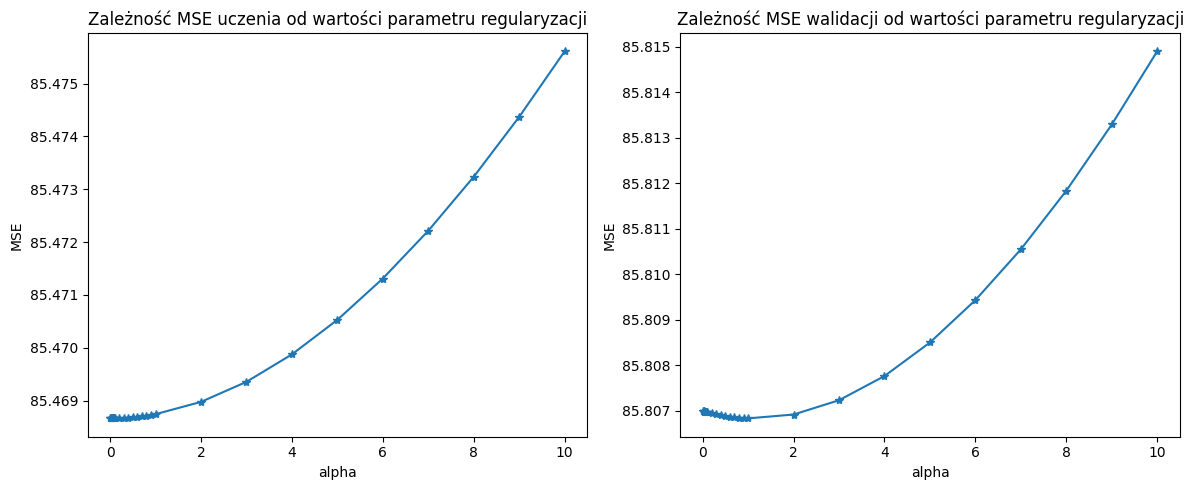

Optimal alpha = 1


In [ ]:
alphas = [i * val for val in [0.01, 0.1, 1] for i in range(1, 10)] + [10]
optimal_alpha = ridge_find_alpha(X_train[forward_chosen_features], y_train, alphas)
print(f'Optimal alpha = {optimal_alpha}')

Optymalną wartością współczynnika regularyzacji, która minimalizuje błąd walidacji jest $\alpha = 1$.

In [ ]:
mse_train8, mse_test8, coefs = ridge_regression(X_train[forward_chosen_features], X_test[forward_chosen_features], y_train, y_test, optimal_alpha)

print(f'MSE train: {mse_train8}')
print(f'MSE test: {mse_test8}\n')

coefs8 = print_coefs(forward_chosen_features, coefs)

MSE train: 85.46874115381118
MSE test: 79.94646014621969

Coefficients:
log_global_radiation: -5.376494705365768
month_cos: -5.34150443123111
month_sin: 4.427798420904955
global_radiation: 4.2433252653668685
mean_temp: -3.1942768453649673
sunshine: -2.790194251287756
log_sunshine: 2.785288142495948
min_temp: 2.2860580533914603
year: 1.4891793495916568
month: -1.0223357366381818
cloud_cover: -0.6144718628945044
max_temp: -0.2759157537721524
precipitation: 0.1638196431045956


**Wnioski:**
* błąd testowy jest mniejszy niż błąd uczący
* wartości obydwu błędów są niemalże identyczne jak dla regresji bez regularyzacji:
    * błąd uczący - minimalnie większy
    * błąd testowy - minimalnie większy
* największy wpływ miała zmienna `log_global_radiation`
* najmniejszy wpływ miała zmienna `precipitation`
* regularyzacja L2 nie poprawia efektywności modelu

##### Regresja Lasso (L1)

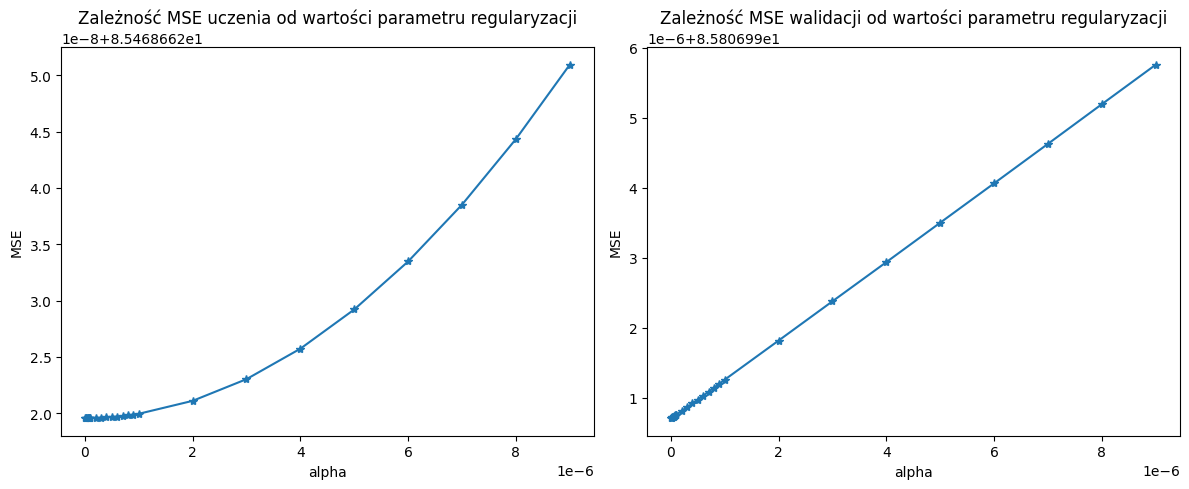

Optimal alpha = 1e-08


In [ ]:
alphas = [i * val for val in [0.00000001, 0.0000001, 0.000001] for i in range(1, 10)]
optimal_alpha = lasso_find_alpha(X_train[forward_chosen_features], y_train, alphas)
print(f'Optimal alpha = {optimal_alpha}')

Błąd walidacji rośnie niezależnie od badanego zakresu poszukiwań współczynnika regularyzacji. Wybrana jest najmniejsza badana wartość $\alpha = 10^{-8}$.

In [ ]:
mse_train9, mse_test9, coefs = lasso_regression(X_train[forward_chosen_features], X_test[forward_chosen_features], y_train, y_test, optimal_alpha)

print(f'MSE train: {mse_train9}')
print(f'MSE test: {mse_test9}\n')

coefs9 = print_coefs(forward_chosen_features, coefs)

MSE train: 85.4686620195627
MSE test: 79.94454343947106

Coefficients:
log_global_radiation: -5.4141980892891395
month_cos: -5.355688830037096
month_sin: 4.425988084194336
global_radiation: 4.263432895542998
mean_temp: -3.222203386075879
log_sunshine: 2.8173407574579428
sunshine: -2.813937715964985
min_temp: 2.305793531342863
year: 1.4889089536043996
month: -1.0237964429215245
cloud_cover: -0.6176856196914446
max_temp: -0.26838553227730805
precipitation: 0.16413463277594756


**Wnioski:**
* błąd testowy jest mniejszy niż błąd uczący
* wartości obydwu błędów są niemalże identyczne jak dla regresji bez regularyzacji:
    * błąd uczący - minimalnie większy
    * błąd testowy - minimalnie większy
* największy wpływ miała zmienna `log_global_radiation`
* najmniejszy wpływ miała zmienna `precipitation`
* regularyzacja L1 nie poprawia efektywności modelu

#### Regresja krokowa w tył

In [ ]:
backward_chosen_features = all_atr.copy()
min_err = float('inf')

while len(backward_chosen_features) > 1:
    feature_to_drop = None

    for f in backward_chosen_features:
        current_features = backward_chosen_features.copy()
        current_features.remove(f)

        err = np.mean(-cross_val_score(lr, X_train[current_features], y_train, cv=5, scoring='neg_mean_squared_error'))

        if err < min_err:
            min_err = err
            feature_to_drop = f

    if feature_to_drop:
        backward_chosen_features.remove(feature_to_drop)
        print(f'Deleting feature: {feature_to_drop}, err = {min_err}')
    else:
        break

print(f'\nChosen features: {backward_chosen_features}, err = {min_err}')

Deleting feature: pressure, err = 85.80023457685986
Deleting feature: max_temp, err = 85.7843070934081
Deleting feature: log_precipitation, err = 85.77586308970726

Chosen features: ['cloud_cover', 'sunshine', 'global_radiation', 'mean_temp', 'min_temp', 'precipitation', 'snow_depth', 'year', 'month', 'month_sin', 'month_cos', 'log_sunshine', 'log_global_radiation', 'log_snow_depth'], err = 85.77586308970726


In [ ]:
list(set(backward_chosen_features) - set(forward_chosen_features))

['log_snow_depth', 'snow_depth']

In [ ]:
list(set(forward_chosen_features) - set(backward_chosen_features))

['max_temp']

**Wnioski - regresja krokowa w tył:**
* wybór 14 z 17 cech
* cechy nieodrzucone przez regresją krokową w tył, których regresja krokowa w przód nie dodała:
    * `snow_depth`
    * `log_snow_depth`
* cechy odrzucone przez regresję krokową w tył, które regresja krokowa w przód dodała:
    * `max_temp`

##### Regresja wieloraka bez regularyzacji

In [ ]:
mse_train10, mse_test10, coefs = linear_regression(X_train[backward_chosen_features], X_test[backward_chosen_features], y_train, y_test)

print(f'MSE train: {mse_train10}')
print(f'MSE test: {mse_test10}\n')

coefs10 = print_coefs(backward_chosen_features, coefs)

MSE train: 85.45041880304444
MSE test: 79.96692829113186

Coefficients:
log_global_radiation: -5.406283464468839
month_cos: -5.299885269513953
month_sin: 4.47844535853262
global_radiation: 4.248056405816468
mean_temp: -3.5444075970973787
log_sunshine: 2.8550472893053076
sunshine: -2.8362758140011968
min_temp: 2.4791339031456268
year: 1.4793243613451736
month: -1.0052472440359
cloud_cover: -0.6132786866434353
log_snow_depth: 0.4333817371111655
snow_depth: -0.3362683518092194
precipitation: 0.17364160200442824


**Wnioski:**
* zwiększenie wartości obydwu błędów w porównaniu do modelu zwierającego wszystkie cechy
* błąd testowy jest mniejszy niż błąd uczący
* największy wpływ miała zmienna z nowych cech `log_global_radiation`
* najmniejszy wpływ miała zmienna `precipitation`
* automatyczny dobór cech poprzez regresję krokową w tył nie poprawił efektywności modelu

##### Regresja grzbietowa (L2)

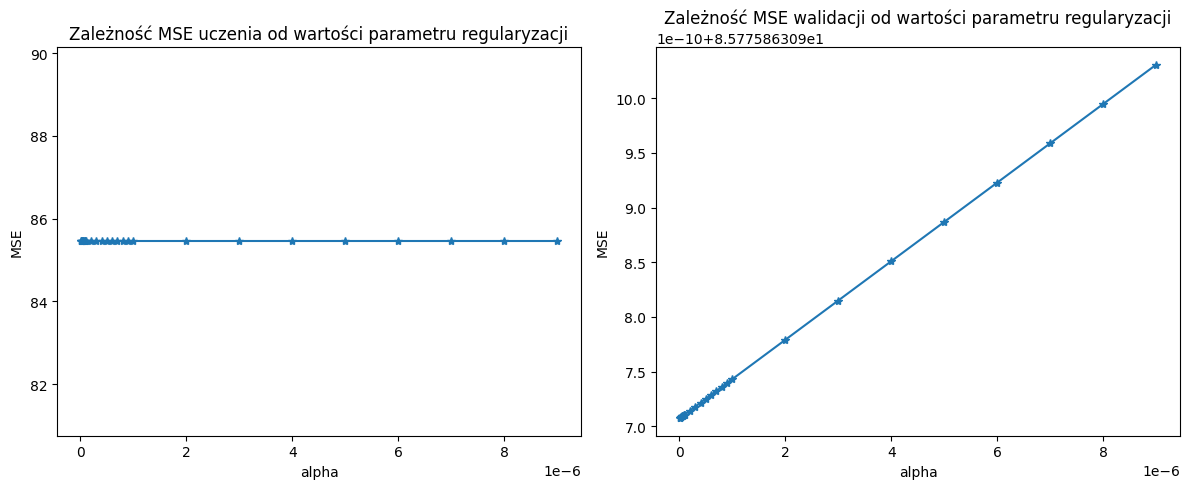

Optimal alpha = 1e-08


In [ ]:
alphas = [i * val for val in [0.00000001, 0.0000001, 0.000001] for i in range(1, 10)]
optimal_alpha = ridge_find_alpha(X_train[backward_chosen_features], y_train, alphas)
print(f'Optimal alpha = {optimal_alpha}')

Błąd walidacji rośnie niezależnie od badanego zakresu poszukiwań współczynnika regularyzacji. Wybrana jest najmniejsza badana wartość $\alpha = 10^{-8}$.

In [ ]:
mse_train11, mse_test11, coefs = ridge_regression(X_train[backward_chosen_features], X_test[backward_chosen_features], y_train, y_test, optimal_alpha)

print(f'MSE train: {mse_train11}')
print(f'MSE test: {mse_test11}\n')

coefs11 = print_coefs(backward_chosen_features, coefs)

MSE train: 85.45041880304446
MSE test: 79.96692829115275

Coefficients:
log_global_radiation: -5.406283464095782
month_cos: -5.299885269359997
month_sin: 4.47844535855978
global_radiation: 4.248056405614029
mean_temp: -3.5444075969054056
log_sunshine: 2.8550472889963863
sunshine: -2.8362758137694626
min_temp: 2.4791339029838766
year: 1.4793243613476452
month: -1.0052472440198656
cloud_cover: -0.613278686607677
log_snow_depth: 0.4333817371119988
snow_depth: -0.3362683518061787
precipitation: 0.17364160200359685


**Wnioski:**
* błąd testowy jest mniejszy niż błąd uczący
* wartości obydwu błędów są niemalże identyczne jak dla regresji bez regularyzacji
* największy wpływ miała zmienna `log_global_radiation`
* najmniejszy wpływ miała zmienna `precipitation`
* regularyzacja L2 nie poprawia efektywności modelu

##### Regresja Lasso (L1)

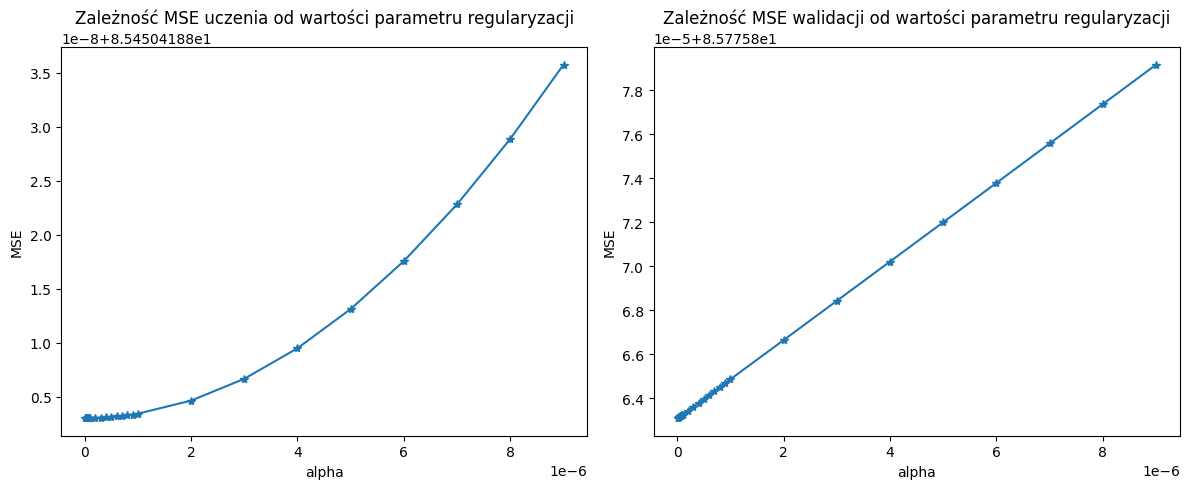

Optimal alpha = 1e-08


In [ ]:
alphas = [i * val for val in [0.00000001, 0.0000001, 0.000001] for i in range(1, 10)]
optimal_alpha = lasso_find_alpha(X_train[backward_chosen_features], y_train, alphas)
print(f'Optimal alpha = {optimal_alpha}')

Błąd walidacji rośnie niezależnie od badanego zakresu poszukiwań współczynnika regularyzacji. Wybrana jest najmniejsza badana wartość $\alpha = 10^{-8}$.

In [ ]:
mse_train12, mse_test12, coefs = lasso_regression(X_train[backward_chosen_features], X_test[backward_chosen_features], y_train, y_test, optimal_alpha)

print(f'MSE train: {mse_train12}')
print(f'MSE test: {mse_test12}\n')

coefs12 = print_coefs(backward_chosen_features, coefs)

MSE train: 85.45041880304449
MSE test: 79.9669283256716

Coefficients:
log_global_radiation: -5.406282740239473
month_cos: -5.299885009797387
month_sin: 4.478445428118234
global_radiation: 4.248055918205332
mean_temp: -3.5444071009232965
log_sunshine: 2.8550466436319923
sunshine: -2.8362752497418176
min_temp: 2.4791334716529705
year: 1.4793243683303876
month: -1.0052471882327692
cloud_cover: -0.6132785765192591
log_snow_depth: 0.4333815906776226
snow_depth: -0.3362681983443823
precipitation: 0.17364158908302949


**Wnioski:**
* błąd testowy jest mniejszy niż błąd uczący
* wartości obydwu błędów są niemalże identyczne jak dla regresji bez regularyzacji
* największy wpływ miała zmienna `log_global_radiation`
* najmniejszy wpływ miała zmienna `precipitation`
* regularyzacja L1 nie poprawia efektywności modelu



---



## Porównanie modeli regresji


### Ważność cech

In [ ]:
models = ['Regresja bez regularyzacji', 'Regresja L2', 'Regresja L1']
models_coefs = [coefs1, coefs2, coefs3]
models_new_features = ['Regresja bez regularyzacji', 'Regresja L2', 'Regresja L1']
models_coefs_new_features = [coefs4, coefs5, coefs6]
models_auto_features_forward = ['Regresja krokowa w przód bez regularyzacji', 'Regresja krokowa w przód L2', 'Regresja krokowa w przód L1']
models_coefs_forward = [coefs7, coefs8, coefs9]
models_auto_features_backward = ['Regresja krokowa w tył bez regularyzacji', 'Regresja krokowa w tył L2', 'Regresja krokowa w tył L1']
models_coefs_backward = [coefs10, coefs11, coefs12]

In [ ]:
color_cycle = plt.cm.tab20c
feature_colors = {}
for feature, color in zip(all_atr, color_cycle.colors):
    feature_colors[feature] = color

def plot_coefs(models, models_coefs, title):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    plt.suptitle(f'{title}', fontsize=16)

    for i, (m, coefs) in enumerate(zip(models, models_coefs)):
        ax = axes[i]
        features, coefficients = zip(*coefs)
        colors = [feature_colors[feature] for feature in features]
        ax.bar(features, coefficients, color=colors)
        ax.set_xticks(range(len(features)))
        ax.set_xticklabels(features, rotation=45, ha='right')
        ax.set_xlabel('Współczynniki')
        ax.set_title(f'{m}')
        ax.grid(axis='y')

    plt.tight_layout()
    plt.show()

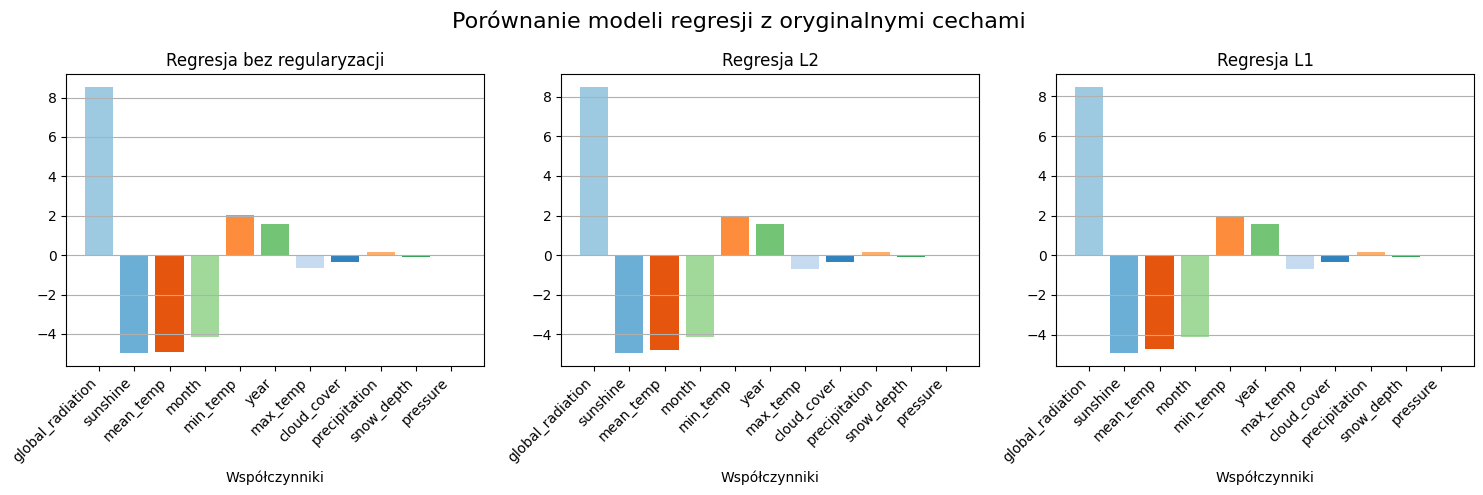

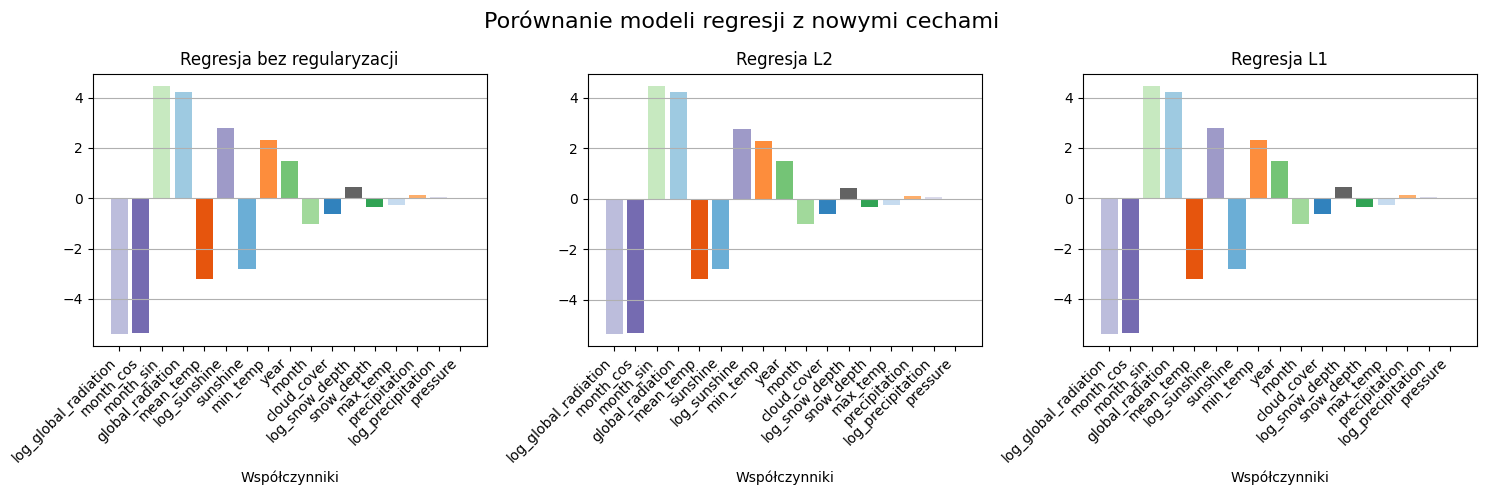

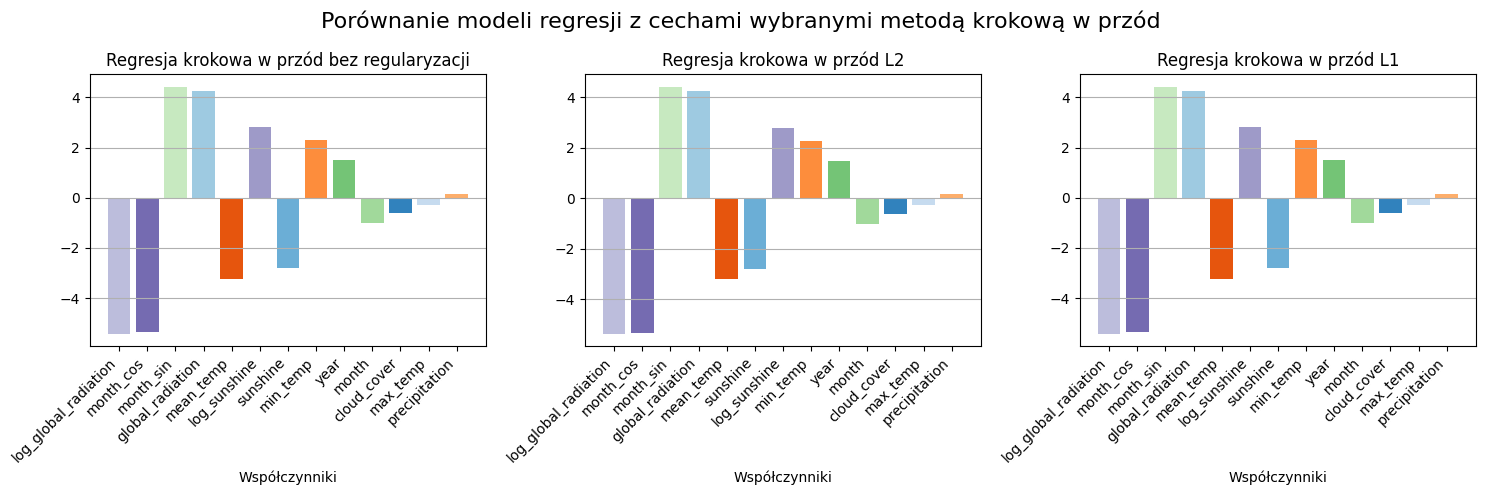

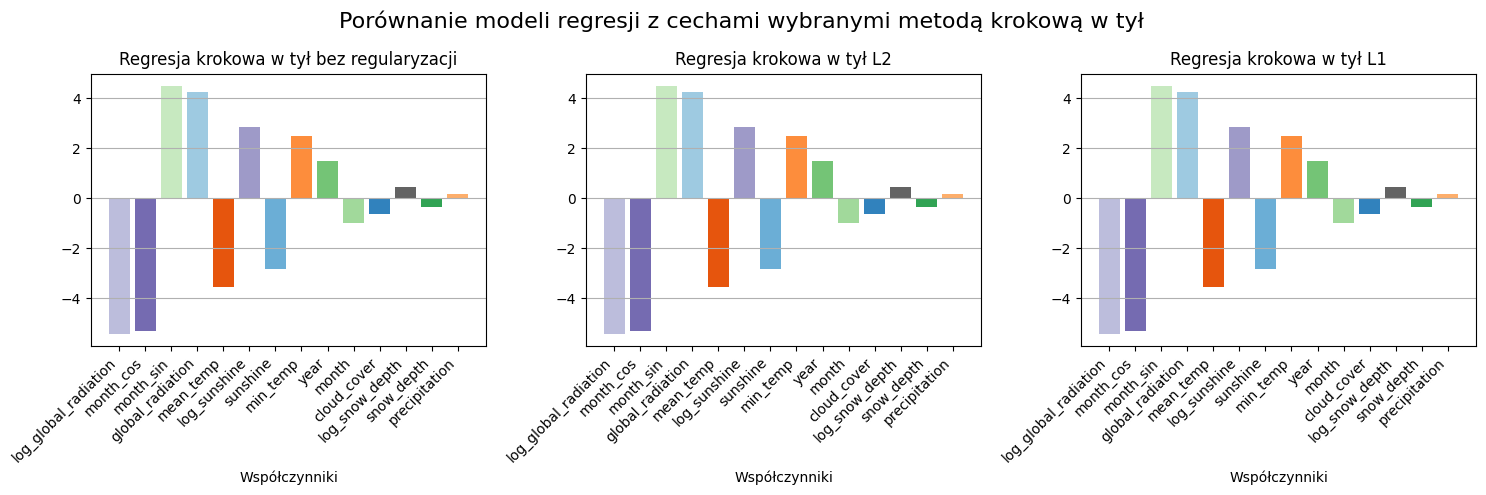

In [ ]:
plot_coefs(models, models_coefs, 'Porównanie modeli regresji z oryginalnymi cechami')
plot_coefs(models_new_features, models_coefs_new_features, 'Porównanie modeli regresji z nowymi cechami')
plot_coefs(models_auto_features_forward, models_coefs_forward, 'Porównanie modeli regresji z cechami wybranymi metodą krokową w przód')
plot_coefs(models_auto_features_backward, models_coefs_backward, 'Porównanie modeli regresji z cechami wybranymi metodą krokową w tył')

**Wnioski na temat ważności cech:**
* modele regresji z oryginalnymi cechami:
    * taki sam rozkład ważności cech dla wszystkich modeli
    * najważniejsza cecha - `global_radiation`
    * najmniej ważna cecha - `pressure`
* modele regresji z nowymi cechami:
    * prawie identyczny rozkład ważności cech dla wszystkich modeli:
        * regresja grzbietowa - `sunshine` ważniejsze od `log_sunshine`
    * najważniejsze cechy - `log_global_radiation` i `month_cos`
    * najmniej ważna cecha - `pressure`
* modele regresji z cechami wybranymi metodą krokową w przód:
    * prawie identyczny rozkład ważności cech dla wszystkich modeli:
        * regresja grzbietowa - `sunshine` ważniejsze od `log_sunshine`
    * najważniejsze cechy - `log_global_radiation` i `month_cos`
    * najmniej ważna cecha - `precipitation`
* modele regresji z cechami wybranymi metodą krokową w przód:
    * taki sam rozkład ważności cech dla wszystkich modeli
    * najważniejsze cechy - `log_global_radiation` i `month_cos`
    * najmniej ważna cecha - `precipitation`

### Błąd uczenia i błąd testowania

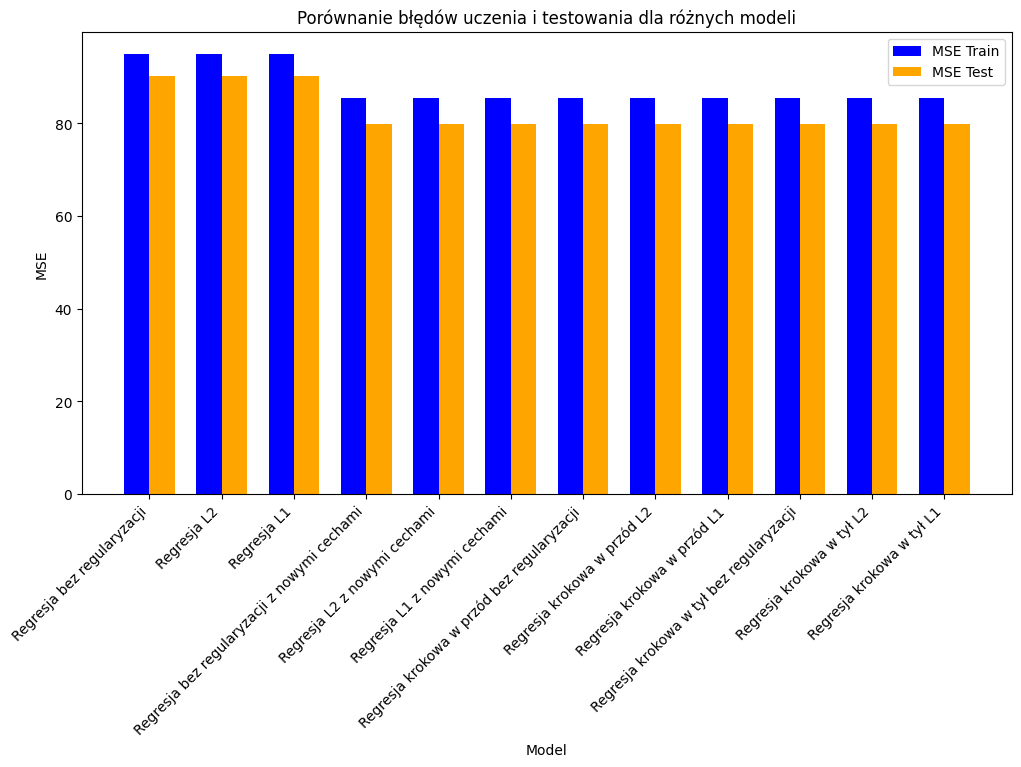

In [ ]:
models = ['Regresja bez regularyzacji', 'Regresja L2', 'Regresja L1',
          'Regresja bez regularyzacji z nowymi cechami', 'Regresja L2 z nowymi cechami', 'Regresja L1 z nowymi cechami',
          'Regresja krokowa w przód bez regularyzacji', 'Regresja krokowa w przód L2', 'Regresja krokowa w przód L1',
          'Regresja krokowa w tył bez regularyzacji', 'Regresja krokowa w tył L2', 'Regresja krokowa w tył L1']
mse_train = [mse_train1, mse_train2, mse_train3, mse_train4, mse_train5, mse_train6, mse_train7, mse_train8, mse_train9, mse_train10, mse_train11, mse_train12]
mse_test = [mse_test1, mse_test2, mse_test3, mse_test4, mse_test5, mse_test6, mse_test7, mse_test8, mse_test9, mse_test10, mse_test11, mse_test12]

plt.figure(figsize=(12, 6))

bar_width = 0.35
index = range(len(models))

plt.bar(index, mse_train, width=bar_width, label='MSE Train', color='blue', align='center')
plt.bar([i + bar_width for i in index], mse_test, width=bar_width, label='MSE Test', color='orange', align='center')

plt.xlabel('Model')
plt.ylabel('MSE')
plt.title('Porównanie błędów uczenia i testowania dla różnych modeli')
plt.xticks([i + bar_width/2 for i in index], models, rotation=45, ha='right')
plt.legend()

plt.show()

In [ ]:
data = list(zip(models, mse_train, mse_test))
headers = ['Model', 'MSE Train', 'MSE Test']
table = tabulate(data, headers=headers, tablefmt="grid")
print(table)

+---------------------------------------------+-------------+------------+
| Model                                       |   MSE Train |   MSE Test |
+=============================================+=============+============+
| Regresja bez regularyzacji                  |     94.9743 |    90.2442 |
+---------------------------------------------+-------------+------------+
| Regresja L2                                 |     94.9747 |    90.2238 |
+---------------------------------------------+-------------+------------+
| Regresja L1                                 |     94.9756 |    90.21   |
+---------------------------------------------+-------------+------------+
| Regresja bez regularyzacji z nowymi cechami |     85.4422 |    79.9383 |
+---------------------------------------------+-------------+------------+
| Regresja L2 z nowymi cechami                |     85.4423 |    79.9399 |
+---------------------------------------------+-------------+------------+
| Regresja L1 z nowymi ce

**Wnioski na temat błędów:**
* największy wpływ na poprawę efektywności modelu miało dodanie nowych cech
* użycie automatycznych metod doboru cech (regresja krokowa w przód i w tył) nie miało wpływu na poprawę efektywności modeli, a nawet ją pogorszyło
* w przypadku modeli z cechami z oryginalnego zbioru danych, obywdie metody regularyzacji w małym stopniu zmniejszyły błąd testowania (przy niewielkim zwiększeniu błędu uczenia)
* w przypadku pozostałych modeli, regularyzacja nie miała wpływu na poprawę efektywności modeli, a nawet w niektórych przypadkach ją nieznacznie pogorszyła (regresja grzbietowa)
* *najlepszy model: regresja bez regularyzacji z nowymi cechami*

In [ ]:
regressor = LinearRegression()

regressor.fit(X_train, y_train)

y_pred_train = regressor.predict(X_train)
y_pred_test = regressor.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

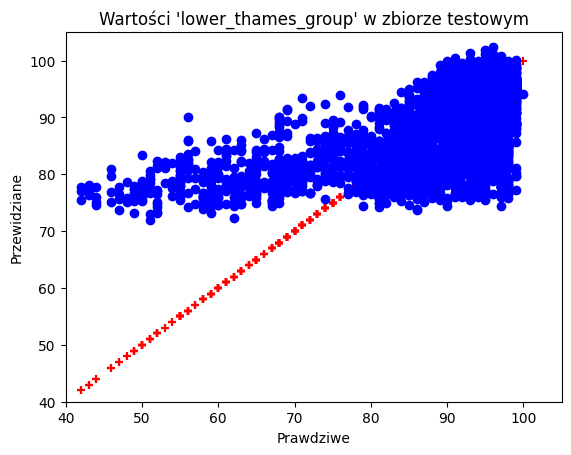

In [ ]:
plt.scatter(y_test, y_test, color='red', marker='+')
plt.scatter(y_test, y_pred_test, color='blue', marker='o')
plt.xlim([40,105])
plt.ylim([40,105])
plt.title("Wartości 'lower_thames_group' w zbiorze testowym")
plt.xlabel('Prawdziwe')
plt.ylabel('Przewidziane')
plt.show()



---



## Wnioski
* ważność współczynników:
    * najważniejszą cechą dla wszystkich modeli była `global_radiation`, czyli natężenie promieniowania - mogło ono wpływać na stopień parowania wody z rezerwuarów
    * oczekiwałyśmy, że cechy związane z opadami (`precipitation` i `snow_depth`) będą miały duży wpływ na wartość zmiennej celu, a okazało się, że były one jednymi z mniej istotnych
* jakość modelu:
    * model ma problem z poprawnym przewidywaniem wartości zmiennej celu dla obserwacji odstających (`lower_thames_group` < 70)
    * możliwe, że cechy, które miałyśmy do dyspozycji, nie opisywały wszystkich czynników wpływających na zmienną celu
    * możliwe, że był innny powód (niezwiązany z pogodą), który wpływał na obniżenie wartości zmiennej celu (np. zwiększony pobór wody z rezerwuarów)
* w przyszłości można sprawdzić:
    * wpływ innych czynników na zmienną celu, np. pobór wody z rezerwuarów lub zużycie wody w Londynie
    * zastosowanie bardziej złożonych modeli